# HW4P2: Attention-based Speech Recognition

<img src="https://cdn.shopify.com/s/files/1/0272/2080/3722/products/SmileBumperSticker_5400x.jpg" alt="A cute cat" width="600">


Welcome to the final assignment in 11785. In this HW, you will work on building a speech recognition system with <i>**attention**</i>. <br> <br>

<center>
<img src="https://popmn.org/wp-content/uploads/2020/03/pay-attention.jpg" alt="A cute cat" height="100">
</center>

<h2>Learning Objectives:

*  **Understand the Transformer Architecture**: Gain a comprehensive understanding of the transformer model architecture.

*  **Develop the  Encoder and Decoder Modules**: Understand the individual components of the transformer's encoder and decoder modules, including positional encoding, multi-head attention, and feed-forward projections.

*  **Integrate the Complete Transformer Model**:  Combine the encoder and decoder modules to construct the full transformer model, and learn how to manage the flow of information between these components.

* **Understand the Value of Multi-Head Attention**: Learn how to use the multi-head attention mechanism and understand its significance in improving the model's ability to focus on different parts of the input sequence simultaneously.

* **Understand and Apply Pretraining Techniques**: Grasp the concept of pretraining by employing LSTMs as an initial embedding mechanism in a transformer's encoder. Learn the strategic process of incrementally training different components of a model — starting with a simple architecture (LSTM), then progressing to more complex structures (transformers). This objective underscores the role of pretraining and its gradual integration to enhance the overall efficacy of neural network models, culminating in superior performance metrics.

* **Enhance Training Efficiency Through Strategic Freezing**: Master the technique of selectively freezing and unfreezing model components at different stages of training. This approach aims to direct the model's learning capacity more effectively, concentrating on specific modules at a time. Understand how this method facilitates a more efficient training process, allowing various parts of the model to adapt incrementally. This objective highlights the value of phased learning, especially beneficial when integrating model components with varying learning dynamics.

*  **Tune Model Hyperparameters**: Experiment with different configurations of model hyperparameters, such as the number of layers, model dimensionality, and the number of attention heads, to help you understand the tradeoff between model complexity and dataset size.

<br>


[Kaggle Competition Link](https://www.kaggle.com/competitions/automatic-speech-recognition-s24)<br>

[Kaggle Dataset Link](https://www.kaggle.com/competitions/automatic-speech-recognition-s24/data)<br>

[Speech Transformer Paper](https://ieeexplore.ieee.org/document/8462506)<br>

[Attention Is All You Need Paper](https://arxiv.org/pdf/1706.03762.pdf)<br>

# Libraries

1. By now, we believe that you are already a great deep learning practitioner, Congratulations. 🎉

2. There are a lot of resources provided in this notebook, that will help you check if you are running your implementations correctly.

In [ ]:
!nvidia-smi

Wed Apr 17 04:31:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0              29W /  70W |   1741MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
''' Installing some required libraries. '''
!pip install python-levenshtein torchsummaryX wandb kaggle pytorch-nlp --quiet

##  Imports

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as tat

from torchsummaryX import summary
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import gc
import os
import math
import yaml
import random
import zipfile
import datetime

import glob
import wandb
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

''' Imports for decoding and distance calculation. '''
import Levenshtein

import warnings
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

Device:  cuda


# Configurations

In [91]:
%%writefile config.yaml

###### Dataset -----------------------------------------------------------------
train_dataset   : "train-clean-100"     # train-clean-50 (primarily for debugging purposes), train-clean-100
cepstral_norm   : True
input_dim       : 27
batch_size      : 64                    # decrease this as you modify the network architecture

###### Encoder Parameters ------------------------------------------
## Universal (Part I and II)
enc_dropout     : 0.2                   # [0.1, 0.4]
## Transformer-related (Part II)
enc_num_layers  : 2                     # [1, 3]
enc_num_heads   : 2                     # [1, 4]

###### Decoder Parameters ------------------------------------------
## Transformer-related (Part I and II)
dec_dropout     : 0.2                   # [0.1, 0.4]
dec_num_layers  : 2                     # [1, 3]
dec_num_heads   : 2                     # [1, 4]

###### Network Parameters ------------------------------------------------------
d_model         : 512                   # [256, 1024]
d_ff            : 2048                  # [512, 4096]

###### Learning Rate ---------------------------------------------------------------
learning_rate   : 1E-4                  # [1E-3, 1E-4], this will depend on the specified optimizer

###### Optimizer ---------------------------------------------------------------
optimizer       : "AdamW"               # Adam, AdamW

## if SGD
momentum        : 0.0
nesterov        : True

###### Scheduler ---------------------------------------------------------------
scheduler       : "ReduceLR"     # CosineAnnealing, ReduceLR

## if ReduceLR

## we are validating every 2 epochs but scheduler acts on every epoch. Set patience accordingly
## patience less than validation frquency can mean learning rate always dropping after patience epochs
## specify a suitable threshold too
factor          : 0.9
patience        : 6

###### Training Parameters -----------------------------------------------------
epochs          : 100

###### Name --------------------------------------------------------------------
Name: ""                                # write your name here for study group

Overwriting config.yaml


In [92]:
with open("config.yaml") as file:
    config = yaml.safe_load(file)

In [93]:
config

{'train_dataset': 'train-clean-100',
 'cepstral_norm': True,
 'input_dim': 27,
 'batch_size': 64,
 'enc_dropout': 0.2,
 'enc_num_layers': 2,
 'enc_num_heads': 2,
 'dec_dropout': 0.2,
 'dec_num_layers': 2,
 'dec_num_heads': 2,
 'd_model': 512,
 'd_ff': 2048,
 'learning_rate': '1E-4',
 'optimizer': 'AdamW',
 'momentum': 0.0,
 'nesterov': True,
 'scheduler': 'ReduceLR',
 'factor': 0.9,
 'patience': 6,
 'epochs': 100,
 'Name': ''}

# Kaggle Dataset Download

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:

    # Enter your kaggle username <USERNAME> and key <KEY> here.
    f.write('{"username":"<USERNAME>","key":"<KEY>"}')

!chmod 600 /root/.kaggle/kaggle.json

  Using cached kaggle-1.5.8-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
''' Downloading the dataset. '''
!kaggle competitions download -c automatic-speech-recognition-s24

''' Unzipping quickly and quietly. '''
!unzip -q automatic-speech-recognition-s24.zip -d ./data

# Character-based LibriSpeech (HW4P2)

In terms of the dataset, the dataset structure for HW3P2 and HW4P2 dataset are very similar.

Can you spot out the differences? What all will be required??

Hints:

- Check how big is the dataset? (do you require memory efficient loading techniques??)
- How do we load MFCCs? Do we need to normalize them?
- Does the data have \<SOS> and \<EOS> tokens in each sequences? Do we remove them or do we not remove them? (Read writeup)
- Would we want a collating function? Ask yourself: Why did we need a collate function last time?
- Observe the VOCAB -- is the dataset same as HW3P2?
- Should you add augmentations, if yes which augmentations? When should you add augmentations? (Check bootcamp for answer)


In [8]:
VOCAB = [
    "<pad>", "<sos>", "<eos>",
    "A",   "B",    "C",    "D",
    "E",   "F",    "G",    "H",
    "I",   "J",    "K",    "L",
    "M",   "N",    "O",    "P",
    "Q",   "R",    "S",    "T",
    "U",   "V",    "W",    "X",
    "Y",   "Z",    "'",    " ",
]

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

PAD_TOKEN = VOCAB_MAP["<pad>"]
SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

print(f"Length of Vocabulary    : {len(VOCAB)}")
print(f"VOCAB                   : {VOCAB}")
print(f"PAD_TOKEN               : {PAD_TOKEN}")
print(f"SOS_TOKEN               : {SOS_TOKEN}")
print(f"EOS_TOKEN               : {EOS_TOKEN}")

Length of Vocabulary    : 31
VOCAB                   : ['<pad>', '<sos>', '<eos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ']
PAD_TOKEN               : 0
SOS_TOKEN               : 1
EOS_TOKEN               : 2


## Dataset

In [9]:
''' This class is very similar to HW3P2 except for targets (now sequence of characters). '''

class SpeechDataset(torch.utils.data.Dataset):
    ''' memory inefficient : loading data in __init__ for simplicty

        You may decide to load data in __getitem__ if you wish.
        However, doing this memory inefficiently makes __init__ function takes
        the load of loading the data, and shifts it away from during the training process.
    '''

    def __init__(self, root_dir, partition, cepstral=True, transforms=True):

        self.transforms = transforms
        self.mfcc_dir           = f"{root_dir}/{partition}*/mfcc/*"
        self.transcript_dir     = f"{root_dir}/{partition}*/transcripts/*"

        self.mfcc_files         = sorted(glob.glob(self.mfcc_dir))
        self.transcript_files   = sorted(glob.glob(self.transcript_dir))

        assert len(self.mfcc_files) == len(self.transcript_files)

        self.mfcc_files         = self.mfcc_files
        self.transcript_files   = self.transcript_files
        self.length             = len(self.transcript_files)
        self.vocab              = VOCAB

        print("Loaded Path: ", partition)

        self.mfccs, self.transcripts_shifted, self.transcripts_golden  = [], [], []
        for file in self.mfcc_files:
            mfcc = np.load(file)

            if cepstral:
                mfcc = (mfcc - np.mean(mfcc, axis=0)) / (np.std(mfcc, axis=0) + 1E-8)
            self.mfccs.append(mfcc)

        for file in self.transcript_files:
            temp = np.load(file)[1:-1]

            # Why do we have two different types of targets?
            # How do we want our decoder to know the start of sequence <SOS> and end of sequence <EOS>?

            # @TODO: Uncomment the code below after answering the above questions.
            self.transcripts_shifted.append(np.array([SOS_TOKEN] + [self.vocab.index(i) for i in temp]))
            self.transcripts_golden.append(np.array([self.vocab.index(i) for i in temp] + [EOS_TOKEN]))

        assert len(self.mfccs) == len(self.transcripts_shifted)


    def __len__(self): return self.length


    def __getitem__(self, ind):
        mfcc                = torch.FloatTensor(self.mfccs[ind])
        shifted_transcript  = torch.tensor(self.transcripts_shifted[ind])
        golden_transcript   = torch.tensor(self.transcripts_golden[ind])

        return mfcc, shifted_transcript, golden_transcript


    def collate_fn(self, batch):
        # @NOTE: batch corresponds to output from __getitem__ for a minibatch

        '''
        1.  Extract the features and labels from 'batch'.
        2.  We will additionally need to pad both features and labels,
            look at PyTorch's documentation for pad_sequence.
        3.  This is a good place to perform transforms, if you so wish.
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lengths of features, and lengths of labels.

        '''

        # Batch of input mfcc coefficients.
        batch_mfcc              = [i[0] for i in batch]

        # Batch of output characters (shifted and golden).
        batch_transcript        = [i[1] for i in batch]
        batch_golden            = [i[2] for i in batch]

        lengths_mfcc            = [len(i) for i in batch_mfcc]
        lengths_transcript      = [len(i) for i in batch_transcript]

        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first).
        batch_mfcc_pad          = pad_sequence(batch_mfcc, batch_first=True, padding_value=PAD_TOKEN)
        batch_transcript_pad    = pad_sequence(batch_transcript, batch_first=True, padding_value=PAD_TOKEN)
        batch_golden_pad        = pad_sequence(batch_golden, batch_first=True, padding_value=PAD_TOKEN)


        # You may apply some transformations, Time and Frequency masking, here in the collate function:
        # Food for Thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?
        if self.transforms == True:
            time_mask = tat.TimeMasking(time_mask_param=80,iid_masks=True)
            frequency_mask = tat.FrequencyMasking(freq_mask_param=2,iid_masks=True)
            batch_mfcc_pad = torch.permute(batch_mfcc_pad, (0, 2, 1))
            batch_mfcc_pad = time_mask(batch_mfcc_pad)
            batch_mfcc_pad = frequency_mask(batch_mfcc_pad)
            batch_mfcc_pad = torch.permute(batch_mfcc_pad, (0, 2, 1))

        # Return the following values:
        # padded features, padded shifted labels, padded golden labels, actual length of features, actual length of the shifted labels
        return batch_mfcc_pad, batch_transcript_pad, batch_golden_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)

In [10]:
class SpeechTestDataset(torch.utils.data.Dataset):

    def __init__(self, root_dir, partition, cepstral=True):

        self.mfcc_dir       = f"{root_dir}/{partition}*/mfcc/*"
        self.mfcc_files     = sorted(glob.glob(self.mfcc_dir))
        self.length         = len(self.mfcc_files)

        self.mfccs = []
        for file in self.mfcc_files:
            mfcc = np.load(file)
            if cepstral: mfcc = (mfcc - np.mean(mfcc, axis=0)) / (np.std(mfcc, axis=0) + 1E-8)
            self.mfccs.append(mfcc)

        print("Loaded Path: ", partition)


    def __len__(self): return self.length


    def __getitem__(self, ind):
        mfcc = self.mfccs[ind]

        return torch.FloatTensor(mfcc)


    def collate_fn(self, batch):
        # @NOTE: batch corresponds to output from __getitem__ for a minibatch

        '''
        TODO:
        1.  Extract the features and labels from 'batch'.
        2.  We will additionally need to pad the features,
            look at PyTorch's documentation for pad_sequence.
        3.  Return batch of features, lengths of features.

        '''

        batch_mfcc      = batch
        batch_mfcc_pad  = pad_sequence(batch_mfcc, batch_first=True)
        lengths_mfcc    = [len(i) for i in batch_mfcc]

        return batch_mfcc_pad, torch.tensor(lengths_mfcc)

In [11]:
# @NOTE: use the config file to specify PARTITION and CEPSTRAL
DATA_DIR        =     '/content/data/11785-HW4P2'      # Enter your data directory here.
PARTITION       = config['train_dataset']             # Enter your training directory here.
CEPSTRAL        = config['cepstral_norm']           # Enter your cepstral_norm parameter here.

train_dataset   = SpeechDataset(
    root_dir    = DATA_DIR,
    partition   = PARTITION,
    cepstral    = CEPSTRAL,
    transforms = True
)

val_dataset     = SpeechDataset(
    root_dir    = DATA_DIR,
    partition   = "dev-clean",
    cepstral    = CEPSTRAL,
    transforms = False
)

test_dataset    = SpeechTestDataset(
    root_dir    = DATA_DIR,
    partition   = "test-clean",
    cepstral    = CEPSTRAL,
)

gc.collect()

Loaded Path:  train-clean-100
Loaded Path:  dev-clean
Loaded Path:  test-clean


735

## DataLoader

In [12]:
train_loader    = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = config["batch_size"],
    shuffle     = True,
    num_workers = 4,
    pin_memory  = True,
    collate_fn  = train_dataset.collate_fn
)

val_loader      = torch.utils.data.DataLoader(
    dataset     = val_dataset,
    batch_size  = config["batch_size"],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True,
    collate_fn  = val_dataset.collate_fn,
)

test_loader     = torch.utils.data.DataLoader(
    dataset     = test_dataset,
    batch_size  = config["batch_size"],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True,
    collate_fn  = test_dataset.collate_fn,
)

print("No. of Train MFCCs   : ", train_dataset.__len__())
print("Batch Size           : ", config["batch_size"])
print("Train Vatches        : ", train_loader.__len__())
print("Val Batches          : ", val_loader.__len__())
print("Test Batches         : ", test_loader.__len__())

No. of Train MFCCs   :  28539
Batch Size           :  64
Train Vatches        :  446
Val Batches          :  43
Test Batches         :  41


In [13]:
''' Sanity Check '''

print("Checking the Shapes of the Data --\n")

for batch in train_loader:
    x_pad, y_shifted_pad, y_golden_pad, x_len, y_len, = batch

    print(f"x_pad shape:\t\t{x_pad.shape}")
    print(f"x_len shape:\t\t{x_len.shape}\n")

    print(f"y_shifted_pad shape:\t{y_shifted_pad.shape}")
    print(f"y_golden_pad shape:\t{y_golden_pad.shape}")
    print(f"y_len shape:\t\t{y_len.shape}\n")

    # print(y_shifted_pad)

    break

Checking the Shapes of the Data --

x_pad shape:		torch.Size([64, 1684, 27])
x_len shape:		torch.Size([64])

y_shifted_pad shape:	torch.Size([64, 263])
y_golden_pad shape:	torch.Size([64, 263])
y_len shape:		torch.Size([64])



## DataLoader Verification

- Train Dataset (train-clean-50)
```
Loaded Path:  train-clean-50
Max MFCC Length          :  1982
Avg MFCC Length          :  1256.06069100848
Max Transcript Length    :  354
Max Transcript Length    :  182.2676431424767
```

- Train Dataset (train-clean-100)
```
Loaded Path:  train-clean-100
Max MFCC Length          :  2448
Avg MFCC Length          :  1264.6258453344547
Max Transcript Length    :  399
Max Transcript Length    :  186.65321139493324
```

- Validation Dataset
```
Loaded Path:  dev-clean
Max MFCC Length          :  3260
Avg MFCC Length          :  713.3570107288198
Max Transcript Length    :  517
Max Transcript Length    :  107.71698113207547
```

- Test Dataset
```
Loaded Path:  test-clean
Max MFCC Length          :  27
Avg MFCC Length          :  27.0
```

- Population Stats
```
Max Length:  3260
```

If your values is not matching, read hints and think what could have gone wrong. Then approach TAs.



In [14]:
def verify_dataset(dataset, partition="train-clean-100"):
    print("Loaded Path: ", partition)

    if partition != "test-clean":
        print("Max MFCC Length          : ", np.max([data[0].shape[0] for data in dataset]))
        print("Avg MFCC Length          : ", np.mean([data[0].shape[0] for data in dataset]))
        print("Max Transcript Length    : ", np.max([data[1].shape[0] for data in dataset]))
        print("Max Transcript Length    : ", np.mean([data[1].shape[0] for data in dataset]))
    else:
        print("Max MFCC Length          : ", np.max([data[0].shape[0] for data in dataset]))
        print("Avg MFCC Length          : ", np.mean([data[0].shape[0] for data in dataset]))

    print()

verify_dataset(train_dataset, partition="train-clean-100")
verify_dataset(val_dataset, partition="dev-clean")
verify_dataset(test_dataset, partition="test-clean")

dataset_max_len = max(
    np.max([data[0].shape[0] for data in train_dataset]),
    np.max([data[0].shape[0] for data in val_dataset]),
    np.max([data[0].shape[0] for data in test_dataset]),
)

print("Max Length: ", dataset_max_len)

Loaded Path:  train-clean-100
Max MFCC Length          :  2448
Avg MFCC Length          :  1264.6258453344547
Max Transcript Length    :  399
Max Transcript Length    :  185.65321139493324

Loaded Path:  dev-clean
Max MFCC Length          :  3260
Avg MFCC Length          :  713.3570107288198
Max Transcript Length    :  517
Max Transcript Length    :  107.71698113207547

Loaded Path:  test-clean
Max MFCC Length          :  27
Avg MFCC Length          :  27.0

Max Length:  3260


# Introduction

Transformers are highly effective for speech recognition tasks because they utilize self-attention mechanisms, enabling them to analyze entire sequences of audio data in one shot. This allows for a nuanced understanding of long-range dependencies and the complex temporal dynamics inherent in speech. Compared to traditional models, transformers offer improved accuracy and efficiency, adeptly handling variations in speech patterns, accents, and intonations; thus, making them exceptionally suitable for advanced speech recognition applications.

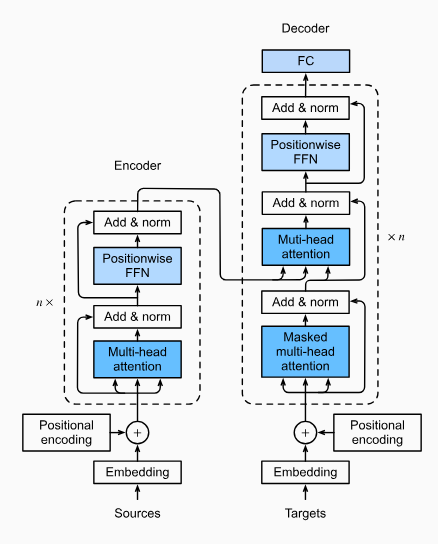

Given the complicated nature of these models, training in this homework will be a little different from other homeworks.<br>
We will employ the following to effectively train the transformer with fewer resources (data and compute power).
<br>
* **Data Complexity and Model Capacity**:  Starting with a CNN-LSTM for input sequences captures temporal dynamics and dependencies early on, simplifying initial learning. This is effective for data with strong temporal or sequential patterns, which LSTMs excel at handling. We will use an already trained model (trained in HW3P2).


* **Gradual (Incremental) Learning**: Starting with a simpler model (like an LSTM) allows the neural network to first learn the basic structures and patterns in the data. When we later introduce more complex mechanisms (like a transformer encoder), the model already has a foundational understanding of the data. This foundation can lead to a smoother and more effective learning process when the complexity of the model increases. In other words, we are using a simple, pretrained LSTM encoder as the basis for our transformer decoder and incrementally adding complexity!

* **Learning Efficiency**: By freezing certain parts of the model during different stages of training, we focus the learning capacity of the network on specific modules, making the training process more efficient. This stepwise unfreezing and training allows different components of the model to adapt gradually, which can be very useful when integrating parts of the model that learn at different rates.

* **Adaptation to Data Characteristics**: This strategy implicitly takes advantage of the data's characteristics by adjusting the model's architecture and training procedure to better suit the data's structure. For instance, if the data contains intricate sequential patterns, starting with an LSTM can harness these patterns effectively. Then, by introducing a transformer encoder, the model can further learn to capture complex, long-range dependencies within the data, something transformers are exceptionally good at.


## Utilities

To make make building the transformer easy, we will define various utility functions and classes which corresponds to the various modules of the transformer. All Components are provided for you but your task will be too understand the modules as you will need  them in answering Canvas quizzes as well as implementing other parts of this notebook. Please refer to the write-up for more information.

In [15]:
def create_mask_1(padded_input, input_lengths=None, pad_idx=None):
    """ Create a mask to identify non-padding positions.

    Args:
        padded_input: The input tensor with padding, shape (N, T, ...) or (N, T).
        input_lengths: Optional, the actual lengths of each sequence before padding, shape (N,).
        pad_idx: Optional, the index used for padding tokens.

    Returns:
        A mask tensor with shape (N, T, 1), where non-padding positions are marked with 1 and padding positions are marked with 0.
    """

    assert input_lengths is not None or pad_idx is not None

    # Create a mask based on input_lengths
    if input_lengths is not None:
        N = padded_input.size(0)        # padded_input : (N x T x ...)
        non_pad_mask = padded_input.new_ones(padded_input.size()[:-1])  # (N x T)

        # Set the mask to 0 for padding positions
        for i in range(N):
          non_pad_mask[i, input_lengths[i]:] = 0

    if pad_idx is not None:             # padded_input : N x T

        assert padded_input.dim() == 2

        # Create a mask where non-padding positions are marked with 1 and padding positions are marked with 0
        non_pad_mask = padded_input.ne(pad_idx).float()

    return non_pad_mask.unsqueeze(-1)   # unsqueeze(-1) for broadcasting

In [16]:
def create_mask_2(seq, pad_idx=None):
    """ Create a mask to prevent positions from attending to subsequent positions.

    Args:
        seq: The input sequence tensor, shape (batch_size, sequence_length).

    Returns:
        A mask tensor with shape (batch_size, sequence_length, sequence_length),
            where positions are allowed to attend to previous positions but not to subsequent positions.
    """

    sz_b, len_s = seq.size()

    # Create an upper triangular matrix with zeros on the diagonal and below (indicating allowed positions)
    #   and ones above the diagonal (indicating disallowed positions)
    subsequent_mask = torch.triu(
        torch.ones((len_s, len_s), device=seq.device, dtype=torch.uint8), diagonal=1)

    # Expand the mask to match the batch size, resulting in a mask for each sequence in the batch.
    mask = subsequent_mask.unsqueeze(0).expand(sz_b, -1, -1)  # b x ls x ls


    ''' Create a mask to ignore padding positions in the key sequence during attention calculation. '''

    # Expanding to fit the shape of key query attention matrix.
    if pad_idx != None:
      len_q = seq.size(1)

      # Create a mask where padding positions in the key sequence are marked with 1.
      padding_mask  = seq.eq(pad_idx)

      # Expand the mask to match the dimensions of the key-query attention matrix.
      padding_mask  = padding_mask.unsqueeze(1).expand(-1, len_q, -1)  # b x lq x lk
      mask          = (padding_mask + mask).gt(0)

    else:
      mask = mask.gt(0)

    return mask

In [17]:
def create_mask_3(padded_input, input_lengths, expand_length):
    """ Create an attention mask to ignore padding positions in the input sequence during attention calculation.

    Args:
        padded_input: The input tensor with padding, shape (N, Ti, ...).
        input_lengths: The actual lengths of each sequence before padding, shape (N,).
        expand_length: The length to which the attention mask should be expanded,
            usually equal to the length of the sequence that the attention scores will be applied to.

    Returns:
        An attention mask tensor with shape (N, expand_length, Ti),
            where padding positions in the input sequence are marked with 1 and other positions are marked with 0.
    """

    # Create a mask to identify non-padding positions, shape (N, Ti, 1)
    # (N x Ti x 1)
    non_pad_mask    = create_mask_1(padded_input, input_lengths=input_lengths)

    # Invert the mask to identify padding positions, shape (N, Ti)
    # N x Ti, lt(1) like-not operation
    pad_mask        = non_pad_mask.squeeze(-1).lt(1)


    # Expand the mask to match the dimensions of the attention matrix, shape (N, expand_length, Ti)
    attn_mask       = pad_mask.unsqueeze(1).expand(-1, expand_length, -1)

    return attn_mask

In [18]:
class ScaledDotProductAttention(torch.nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature    = temperature                       # Scaling factor for the dot product
        self.dropout        = torch.nn.Dropout(attn_dropout)    # Dropout layer for attention weights
        self.softmax        = torch.nn.Softmax(dim=2)           # Softmax layer along the attention dimension

    def forward(self, q, k, v, mask=None):

        # Calculate the dot product between queries and keys.
        attn = torch.bmm(q, k.transpose(1, 2))

        # Scale the dot product by the temperature.
        attn = attn / self.temperature

        if mask is not None:
            # Apply the mask by setting masked positions to a large negative value.
            # This ensures they have a softmax score close to zero.
            mask_value = -1e+30 if attn.dtype == torch.float32 else -1e+4
            attn = attn.masked_fill(mask, mask_value)

        # Apply softmax to obtain attention weights.
        attn    = self.softmax(attn)

        # Apply dropout to the attention weights.
        attn    = self.dropout(attn)

        # Compute the weighted sum of values based on the attention weights.
        output  = torch.bmm(attn, v)

        return output, attn # Return the attention output and the attention weights.

In [19]:
def save_attention_plot(attention_weights, epoch=0):
    ''' function for saving attention weights plot to a file

        @NOTE: default starter code set to save cross attention
    '''

    plt.clf()  # Clear the current figure
    sns.heatmap(attention_weights, cmap="GnBu")  # Create heatmap

    # Save the plot to a file. Specify the directory if needed.
    plt.savefig(f"cross_attention-epoch{epoch}.png")

In [20]:
class MultiHeadAttention(torch.nn.Module):
    ''' Multi-Head Attention Module '''

    def __init__(self, n_head, d_model, dropout=0.1):
        super().__init__()

        self.n_head = n_head # Number of attention heads
        self.d_k    = d_model // n_head
        self.d_v    = d_model // n_head


        # Linear layers for projecting the input query, key, and value to multiple heads
        self.w_qs   = torch.nn.Linear(d_model, n_head * self.d_k)
        self.w_ks   = torch.nn.Linear(d_model, n_head * self.d_k)
        self.w_vs   = torch.nn.Linear(d_model, n_head * self.d_v)

        torch.nn.init.normal_(self.w_qs.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_k)))
        torch.nn.init.normal_(self.w_ks.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_k)))
        torch.nn.init.normal_(self.w_vs.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_v)))

        # Initialize the weights of the linear layers
        self.attention = ScaledDotProductAttention(
            temperature=np.power(self.d_k, 0.5), attn_dropout=dropout)

        # Final linear layer to project the concatenated outputs of the attention heads back to the model dimension
        self.fc = torch.nn.Linear(n_head * self.d_v, d_model)

        torch.nn.init.xavier_normal_(self.fc.weight)

        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):

        # following key, value, query standard computation
        d_k, d_v, n_head    = self.d_k, self.d_v, self.n_head
        sz_b, len_q, _      = q.size()
        sz_b, len_k, _      = k.size()
        sz_b, len_v, _      = v.size()

        # Project the input query, key, and value to multiple heads
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        # Rearrange the dimensions to group the heads together for parallel processing
        q = q.permute(2, 0, 1, 3).contiguous().view(-1, len_q, d_k) # (n*b) x lq x dk
        k = k.permute(2, 0, 1, 3).contiguous().view(-1, len_k, d_k) # (n*b) x lk x dk
        v = v.permute(2, 0, 1, 3).contiguous().view(-1, len_v, d_v) # (n*b) x lv x dv

        # Repeat the mask for each attention head if a mask is provided
        if mask is not None:
            mask = mask.repeat(n_head, 1, 1)

        # Apply scaled dot-product attention to the projected query, key, and value
        output, attn    = self.attention(q, k, v, mask=mask)

        # Rearrange the output back to the original order and concatenate the heads
        output          = output.view(n_head, sz_b, len_q, d_v)
        output          = output.permute(1, 2, 0, 3).contiguous().view(sz_b, len_q, -1) # b x lq x (n*dv)

        output          = self.dropout(self.fc(output))

        return output, attn

## Transformer Modules

### Positional Encoding

In [21]:
class PositionalEncoding(torch.nn.Module):
    ''' Position Encoding from Attention Is All You Need Paper '''

    def __init__(self, d_model, max_len=5000):
        super().__init__()

        # Initialize a tensor to hold the positional encodings
        pe          = torch.zeros(max_len, d_model)

        # Create a tensor representing the positions (0 to max_len-1)
        position    = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Calculate the division term for the sine and cosine functions
        # This term creates a series of values that decrease geometrically, used to generate varying frequencies for positional encodings
        div_term    = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Compute the positional encodings using sine and cosine functions
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Reshape the positional encodings tensor and make it a buffer
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):

      return x + self.pe[:, :x.size(1)]

### Feed Forward Networks

In [22]:
class FeedForward(torch.nn.Module):
    ''' Projection Layer (Fully Connected Layers) '''

    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()

        self.linear_1   = torch.nn.Linear(d_model, d_ff)
        self.dropout    = torch.nn.Dropout(dropout)
        self.linear_2   = torch.nn.Linear(d_ff, d_model)

    def forward(self, x):

        # Apply the first linear layer, GeLU activation, and then dropout
        x = self.dropout(torch.nn.functional.gelu(self.linear_1(x)))

         # Apply the second linear layer to project the dimension back to d_model
        x = self.linear_2(x)

        return x

# PART #1 (Preliminary Submission)

In this part we will use a simple CNN-LSTM as an encoder with a Transformer Decoder (with Self-Attention and Cross-Attention).

## CNN-LSTM Encoder

In [23]:
class Permute(nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

In [24]:
class pBLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()
        self.blstm = torch.nn.LSTM(input_size=2*input_size, hidden_size=hidden_size, bidirectional=True, batch_first=True)

    def forward(self, x_packed):
        x_padded, x_lens = pad_packed_sequence(x_packed, batch_first=True)
        x_padded, x_lens = self.trunc_reshape(x_padded, x_lens)
        x_packed = pack_padded_sequence(x_padded, x_lens, batch_first=True, enforce_sorted=False)
        output_packed, hidden = self.blstm(x_packed)
        return output_packed

    def trunc_reshape(self, x, x_lens):
        if x.shape[1]%2==1:
            x = x[:,:-1,:]
        x = x.reshape((x.shape[0], int(x.shape[1]//2), x.shape[2]*2))
        x_lens = (x_lens/2).type(torch.int)
        return x, x_lens

In [25]:
from torch.autograd import Variable

class LockedDropout(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.dropout = dropout

    def forward(self, x):
        if not self.training or not self.dropout:
            return x
        x_unpacked, x_lens = pad_packed_sequence(x, batch_first=True)
        m = x.data.new(x_unpacked.size(0), 1, x_unpacked.size(2)).bernoulli_(1 - self.dropout)
        mask = Variable(m, requires_grad=False) / (1 - self.dropout)
        mask = mask.expand_as(x_unpacked)
        out = mask * x_unpacked
        return pack_padded_sequence(out, lengths=x_lens, batch_first=True, enforce_sorted=False)

In [26]:
class CNN_LSTM_Encoder(torch.nn.Module):
    ''' The Encoder takes utterances as inputs and returns latent feature representations '''

    def __init__(self, input_size, encoder_hidden_size, enc_dropout=0.2):
        super(CNN_LSTM_Encoder, self).__init__()

        self.embedding = torch.nn.Sequential(
            torch.nn.Conv1d(input_size, 2*input_size, kernel_size=5, stride=1, padding=2),
            torch.nn.BatchNorm1d(2*input_size),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv1d(2*input_size, 4*input_size, kernel_size=5, stride=1, padding=2),
            torch.nn.BatchNorm1d(4*input_size),
            torch.nn.ReLU(inplace=True)
        )

        self.bilstm = torch.nn.LSTM(input_size=4*input_size, hidden_size=encoder_hidden_size, bidirectional=True, batch_first=True, dropout=enc_dropout)

        self.pBLSTMs = torch.nn.Sequential(
            pBLSTM(2 * encoder_hidden_size, encoder_hidden_size),
            LockedDropout(dropout=2*enc_dropout),
            pBLSTM(2*encoder_hidden_size, 2*encoder_hidden_size),
            LockedDropout(dropout=enc_dropout),
        )

        self.permute = Permute()

    def forward(self, x, x_lens):
        x = self.permute(x)
        x = self.embedding(x)
        x = self.permute(x)

        x_packed        = pack_padded_sequence(x, x_lens, batch_first= True, enforce_sorted=False)
        x_packed, _     = self.bilstm(x_packed)
        x_packed        = self.pBLSTMs(x_packed)
        encoder_outputs, encoder_lens = pad_packed_sequence(x_packed, batch_first=True)

        return encoder_outputs, encoder_lens

## HW3P2 model



### Pyramid Bi-LSTM (pBLSTM)

In [ ]:
# Utils for network
torch.cuda.empty_cache()
# from torch.autograd import Variable

class PermuteBlock(torch.nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

class LockedDropout(nn.Module):
    """ LockedDropout applies the same dropout mask to every time step.

    **Thank you** to Sales Force for their initial implementation of :class:`WeightDrop`. Here is
    their `License
    <https://github.com/salesforce/awd-lstm-lm/blob/master/LICENSE>`__.

    Args:
        p (float): Probability of an element in the dropout mask to be zeroed.
    """

    def __init__(self, p=0.25):
        self.p = p
        super().__init__()

    def forward(self, x):
        """
        Args:
            x (:class:`torch.FloatTensor` [sequence length, batch size, rnn hidden size]): Input to
                apply dropout too.
        """
        if not self.training or not self.p:
            return x
        x = x.clone()
        mask = x.new_empty(1, x.size(1), x.size(2), requires_grad=False).bernoulli_(1 - self.p)
        mask = mask.div_(1 - self.p)
        mask = mask.expand_as(x)
        return x * mask


    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'p=' + str(self.p) + ')'


In [ ]:
class pBLSTM(torch.nn.Module):

    '''
    Pyramidal BiLSTM
    Read the write up/paper and understand the concepts and then write your implementation here.

    At each step,
    1. Pad your input if it is packed (Unpack it)
    2. Reduce the input length dimension by concatenating feature dimension
        (Tip: Write down the shapes and understand)
        (i) How should  you deal with odd/even length input?
        (ii) How should you deal with input length array (x_lens) after truncating the input?
    3. Pack your input
    4. Pass it into LSTM layer

    To make our implementation modular, we pass 1 layer at a time.
    '''

    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()

        self.blstm = torch.nn.LSTM(input_size=2*input_size, hidden_size=hidden_size, num_layers=3, bidirectional=True, dropout = 0.3)  # TODO: Initialize a single layer bidirectional LSTM with the given input_size and hidden_size
        #could drop out
    def forward(self, x_packed): # x_packed is a PackedSequence

        # TODO: Pad Packed Sequence
        seq_unpacked, lens_unpacked = pad_packed_sequence(x_packed, batch_first=True)
        # print(f'in the plstm section after pad {seq_unpacked.shape},{lens_unpacked.shape}')
        # Call self.trunc_reshape() which downsamples the time steps of x and increases the feature dimensions as mentioned above
        x, x_lens = self.trunc_reshape(x=seq_unpacked, x_lens=lens_unpacked)
        # print(f'in the plstm section after truncate {x.shape},{x_lens.shape}')
        # self.trunc_reshape will return 2 outputs. What are they? Think about what quantites are changing.
        # TODO: Pack Padded Sequence. What output(s) would you get?
        PackedSequence = pack_padded_sequence(input=x,lengths=x_lens,batch_first=True,enforce_sorted=False)
        # TODO: Pass the sequence through bLSTM
        packed_output, (_, _) = self.blstm(PackedSequence)
        # What do you return?

        return packed_output

    def trunc_reshape(self, x, x_lens):
        # TODO: If you have odd number of timesteps, how can you handle it? (Hint: You can exclude them)
        # TODO: Reshape x. When reshaping x, you have to reduce number of timesteps by a downsampling factor while increasing number of features by the same factor
        # TODO: Reduce lengths by the same downsampling factor
        # The shape of x is [batch_size, frames, features]
        batch_size = x.shape[0]
        frames = x.shape[1]
        features = x.shape[2]
        if frames % 2 != 0:
            x = x[:, :-1, :]
        x = x.reshape((batch_size, x.shape[1]//2, features*2))
        x_lens = x_lens/2
        return x, x_lens

### Encoder

In [ ]:
class Encoder_HW3(torch.nn.Module):
    '''
    The Encoder takes utterances as inputs and returns latent feature representations
    '''
    def __init__(self, input_size, encoder_hidden_size):
        super(Encoder_HW3, self).__init__()

        self.PermuteBlock = PermuteBlock()
        self.embedding = torch.nn.Sequential(torch.nn.Conv1d(in_channels=input_size,out_channels=64,kernel_size=3,padding=1,stride=1),
                                             torch.nn.BatchNorm1d(64),
                                             torch.nn.GELU(),
                                             torch.nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
                                             torch.nn.BatchNorm1d(128),
                                             torch.nn.GELU(),
                                             torch.nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
                                             torch.nn.BatchNorm1d(256),
                                             torch.nn.GELU()
                                             )
        self.lstm_layers = torch.nn.ModuleList()
        for i in range(2):
            input_size_pblstm = 256 if i == 0 else encoder_hidden_size * 2
            self.lstm_layers.append(pBLSTM(input_size=input_size_pblstm, hidden_size=encoder_hidden_size))
            self.lstm_layers.append(LockedDropout())

    def forward(self, x, x_lens):
        # Where are x and x_lens coming from? The dataloader
        #TODO: Call the permute layer and embedding layer
        x = self.PermuteBlock(x)
        x = self.embedding(x)
        x = self.PermuteBlock(x)
        # # TODO: Pack Padded Sequence
        # packed = pack_padded_sequence(input=x,lengths=x_lens,batch_first=True,enforce_sorted=False)
        # # TODO: Pass Sequence through the pyramidal Bi-LSTM layer
        # x = self.pBLSTM1(packed)
        # # TODO: Pad Packed Sequence
        # encoder_outputs, encoder_lens= pad_packed_sequence(sequence=x,batch_first=True)
        # print(f'The output from plstm, {encoder_outputs.shape},{encoder_lens.shape}')
        for layer in self.lstm_layers:
            if isinstance(layer, pBLSTM):
                x_packed = pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)
                x_packed = layer(x_packed)
                x, x_lens = pad_packed_sequence(x_packed, batch_first=True)
            else:
                x = torch.permute(x, (1, 0, 2))
                x = layer(x)
                x = torch.permute(x,(1,0,2))
        # Remember the number of output(s) each function returns

        return x, x_lens


### Decoder

In [ ]:
class HW3P2_encoder(torch.nn.Module):

    def __init__(self, input_size, embed_size= 192):
        super().__init__()

        self.encoder        = Encoder_HW3(input_size=input_size, encoder_hidden_size=embed_size*2)

    def forward(self, x, lengths_x):

        encoder_out, encoder_lens   = self.encoder(x, lengths_x)
        return encoder_out, encoder_lens

## Transformer Decoder

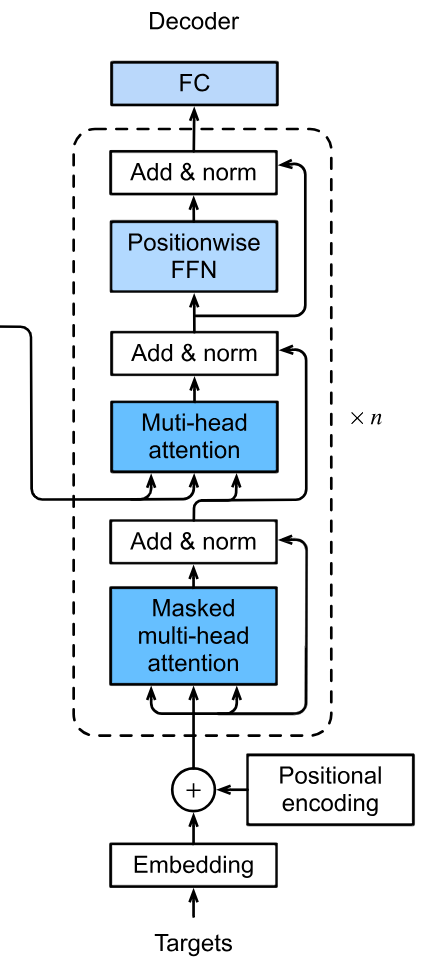

Tips to complete the Decoder below.

* Can you seperate the decoder layers from the whole decoder?
* How many multi-head attention do we have in the figure above.
* How many layer normalizations?
* How do we make the residual connections?

For Forward Method:
* What are the inputs to various multi-head attention modules?
* How do we make the residual connection (do we need dropout)?


In [27]:
class DecoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        # @TODO: fill in the blanks appropriately (given the modules above)
        self.mha1       = MultiHeadAttention(n_head = num_heads, d_model = d_model, dropout=dropout)
        self.mha2       = MultiHeadAttention(n_head = num_heads, d_model=d_model, dropout=dropout)
        self.ffn        = FeedForward(d_model=d_model, d_ff=d_ff, dropout=dropout) # this d_ff might be different from dcoder layer

        self.layernorm1 = torch.nn.LayerNorm(normalized_shape=d_model)
        self.layernorm2 = torch.nn.LayerNorm(normalized_shape=d_model)
        self.layernorm3 = torch.nn.LayerNorm(normalized_shape=d_model)

        self.dropout1   = torch.nn.Dropout(p=dropout)
        self.dropout2   = torch.nn.Dropout(p=dropout)
        self.dropout3   = torch.nn.Dropout(p=dropout)


    def forward(self, padded_targets, enc_output, enc_input_lengths, dec_enc_attn_mask, pad_mask, slf_attn_mask):

        # Masked Multi-Head Attention
        #   (1) apply MHA with the lookahead mask
        ''' TODO '''
        attn_output1, attention_weights1  = self.mha1(q=padded_targets, k=padded_targets, v=padded_targets, mask=slf_attn_mask) # here the padded_targets is (batch, length, d_model)
        # Skip (Residual) Connections
        #   (1) perform dropout on padded attention output
        #   (2) add the true outputs (padded_targets) as a skip connection
        ''' TODO '''
        out1 = padded_targets + self.dropout1(attn_output1)  # or out1 = padded_targets + self.dropout1(attn_output1)
        # Layer Normalization
        #   (1) call layernorm on this resulting value
        ''' TODO '''
        normalized1 = self.layernorm1(out1)
        # Masked Multi-Head Attention on Encoder Outputs and Targets
        #   (1) apply MHA with the self-attention mask
        ''' TODO '''
        attn_output2, attention_weights2 = self.mha2(q=normalized1, k=enc_output, v=enc_output, mask=dec_enc_attn_mask) # this a question
        # Skip (Residual) Connections
        #   (1) perform dropout on this second padded attention output
        #   (2) add the output of first MHA block as a skip connection
        ''' TODO '''
        out2 = normalized1 + self.dropout2(attn_output2)
        # Layer Normalization
        #   (1) call layernorm on this resulting value
        ''' TODO '''
        normalized2 = self.layernorm2(out2)
        # Feed Forward Network
        #   (1) pass through the FFN
        ''' TODO '''
        FFN_out = self.ffn(normalized2)
        # Skip (Residual) Connections
        #   (1) perform dropout on the output
        #   (2) add the output of second MHA block as a skip connection
        ''' TODO '''
        out3 = self.dropout3(FFN_out) + normalized2
        # apply Layer Normalization onto output of feed-forward network
        ''' TODO '''
        normalized3 = self.layernorm3(out3)
        return normalized3, attention_weights1, attention_weights2

In [28]:
class Decoder(torch.nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout,
            target_vocab_size, max_seq_length, eos_token, sos_token, pad_token):
        super().__init__()

        self.EOS_TOKEN      = eos_token
        self.SOS_TOKEN      = sos_token
        self.PAD_TOKEN      = pad_token

        self.max_seq_length = max_seq_length
        self.num_layers     = num_layers

        # use torch.nn.ModuleList() with list comprehension looping through num_layers
        # @NOTE: think about what stays constant per each DecoderLayer (how to call DecoderLayer)
        # @HINT: We've implemented this for you.
        self.dec_layers = torch.nn.ModuleList(
            [DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)]
        )

        self.target_embedding = torch.nn.Embedding(target_vocab_size, d_model, padding_idx=self.PAD_TOKEN)
        self.positional_encoding    = PositionalEncoding(d_model=d_model, max_len=max_seq_length)
        self.final_linear           = torch.nn.Sequential(torch.nn.Linear(d_model, target_vocab_size))
        self.dropout                = torch.nn.Dropout(p=dropout)
        self.layernorm        = torch.nn.LayerNorm(d_model)

    def forward(self, padded_targets, enc_output, enc_input_lengths):

        # create a padding mask for the padded_targets with <PAD_TOKEN>
        ''' TODO '''
        # print(f'The shape for padded_target: {padded_targets.shape}')
        # print(f'The shape for encoder output: {enc_output.shape}')
        # print(f'The shape for encoder input length: {enc_input_lengths.shape}')
        # The shape for padded_target: torch.Size([64, 332])
        # The shape for encoder output: torch.Size([64, 1625, 512])
        # The shape for encoder input length: torch.Size([64])
        padding_mask = create_mask_1(padded_targets, pad_idx=self.PAD_TOKEN)
        # print(f'The shape after padding mask: {padding_mask.shape}')
        """ Create a mask to identify non-padding positions.

        Args:
          padded_input: The input tensor with padding, shape (N, T, ...) or (N, T).
          input_lengths: Optional, the actual lengths of each sequence before padding, shape (N,).
          pad_idx: Optional, the index used for padding tokens.

        Returns:
          A mask tensor with shape (N, T, 1), where non-padding positions are marked with 1 and padding positions are marked with 0.
        """

        # creating an attention mask for the future subsequences (look-ahead mask)
        ''' TODO '''
        look_ahead_mask =  create_mask_2(padded_targets, pad_idx=self.PAD_TOKEN)
        # print(f'The shape after look ahead mask: {look_ahead_mask.shape}')
        """ Create a mask to prevent positions from attending to subsequent positions.

        Args:
          seq: The input sequence tensor, shape (batch_size, sequence_length).

        Returns:
            A mask tensor with shape (batch_size, sequence_length, sequence_length),
            where positions are allowed to attend to previous positions but not to subsequent positions.
        """
        # creating attention mask to ignore padding positions in the input sequence during attention calculation
        ''' TODO '''
        attn_mask = create_mask_3(padded_input=enc_output, input_lengths=enc_input_lengths, expand_length=padded_targets.size(1))
        # print(f'The shape after attn mask: {attn_mask.shape}')
        """ Create an attention mask to ignore padding positions in the input sequence during attention calculation.

        Args:
          padded_input: The input tensor with padding, shape (N, Ti, ...).
          input_lengths: The actual lengths of each sequence before padding, shape (N,).
          expand_length: The length to which the attention mask should be expanded,
            usually equal to the length of the sequence that the attention scores will be applied to.

        Returns:
          An attention mask tensor with shape (N, expand_length, Ti),
            where padding positions in the input sequence are marked with 1 and other positions are marked with 0.
        """
        # computing embeddings for the target sequence
        embedding = self.target_embedding.forward(padded_targets)  # the shape is [batch, target_time_length, dmodel]
        # print(f'The shape after embedding: {embedding.shape}')
        # computing Positional Encodings with the embedded targets
        out = self.positional_encoding.forward(embedding)   # positional encoding doesn't change the shape the shape is [batch, target_time_length, dmodel]
        # out = self.dropout(out)
        # print(f'The shape after positional encoding: {out.shape}')
        # passing through decoder layers
        ''' TODO '''
        # i=0
        all_attention_weights = {}
        for i, layer in enumerate(self.dec_layers):
            out, attention_weights1, attention_weights2 = layer(padded_targets = out, enc_output = enc_output, enc_input_lengths = enc_input_lengths, dec_enc_attn_mask = attn_mask, pad_mask = padding_mask, slf_attn_mask = look_ahead_mask)
            all_attention_weights[f'layer_{i+1}_weight1'] = attention_weights1   # I Think shape is (batch_size, target_time_length, target_time_length)
            all_attention_weights[f'layer_{i+1}_weight2'] = attention_weights2   # I Think shape is (batch_size, target_time_length, input time length)
        # linear layer (Final Projection) for next character prediction
        ''' TODO '''
        # out = self.layernorm(out)
        out = self.final_linear(out)
        return out, all_attention_weights


    def recognize_greedy_search(self, enc_outputs, enc_input_lengths):
        ''' passes the encoder outputs and its corresponding lengths through autoregressive network

            @NOTE: You do not need to make changes to this method.
        '''

        batch_size = enc_outputs.size(0)

        # start with the <SOS> token for each sequence in the batch
        target_seq = torch.full((batch_size, 1), self.SOS_TOKEN, dtype=torch.long).to(enc_outputs.device)

        finished = torch.zeros(batch_size, dtype=torch.bool).to(enc_outputs.device)

        for _ in range(self.max_seq_length):

            # preparing attention masks
            # filled with ones becaues we want to attend to all the elements in the sequence
            pad_mask = torch.ones_like(target_seq).float().unsqueeze(-1)  # (batch_size x i x 1)
            slf_attn_mask_subseq = create_mask_2(target_seq)

            x = self.positional_encoding(self.target_embedding(target_seq))

            for i in range(self.num_layers):
                x, block1, block2 = self.dec_layers[i](
                    x, enc_outputs, enc_input_lengths, None, pad_mask, slf_attn_mask_subseq)

            seq_out = self.final_linear(x[:, -1])
            logits = torch.nn.functional.log_softmax(seq_out, dim=1)

            # selecting the token with the highest probability
            # @NOTE: this is the autoregressive nature of the network!
            next_token = logits.argmax(dim=-1).unsqueeze(1)

            # appending the token to the sequence
            target_seq = torch.cat([target_seq, next_token], dim=-1)

            # checking if <EOS> token is generated
            eos_mask = next_token.squeeze(-1) == self.EOS_TOKEN
            # or opration, if both or one of them is true store the value of the finished sequence in finished variable
            finished |= eos_mask

            # end if all sequences have generated the EOS token
            if finished.all(): break

        # remove the initial <SOS> token and pad sequences to the same length
        target_seq = target_seq[:, 1:]
        max_length = target_seq.size(1)
        target_seq = torch.nn.functional.pad(target_seq,
            (0, self.max_seq_length - max_length), value=self.PAD_TOKEN)

        return target_seq

## CNN-LSTM Encoder + Speech Transformer Decoder

In this section, let's build the first (simplest) Transformer network by combining the CNN-LSTM encoder and our Transformer Decoder.

In [29]:
class SpeechTransformer(torch.nn.Module):

    def __init__(self, input_dim, dec_num_layers, dec_num_heads,
                    d_model, d_ff, target_vocab_size, eos_token, sos_token,
                    pad_token, enc_dropout, dec_dropout, max_seq_length=512):

        super(SpeechTransformer, self).__init__()

        # self.encoder    = CNN_LSTM_Encoder(input_dim, 256, enc_dropout)
        self.encoder    = HW3P2_encoder(input_size=input_dim)


        # self.proj       = torch.nn.Linear(1024, d_model)
        self.proj       = torch.nn.Linear(192*4, d_model)

        # @NOTE: layernorm here is meant to normalize the dynamic ranges of
        #   the cross attention weights such that the model doesn't bias
        #   itself to only using the cross attention weights and neglect using
        #   the multi-head self attention weights.
        #   This is to enfoce the Language Model constraints in the Decoder.
        #   This is an experimental change -- you may try it if you want.
        self.layernorm  = torch.nn.LayerNorm(d_model)

        self.decoder    = Decoder(dec_num_layers, d_model, dec_num_heads, d_ff,
                dec_dropout, target_vocab_size, max_seq_length, eos_token, sos_token, pad_token)

        # You can experiment with different weight initialization schemes or no initialization here
        for p in self.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)

    def forward(self, padded_input, input_lengths, padded_target, target_lengths):

        # passing through Encoder
        encoder_output, encoder_lens = self.encoder(padded_input, input_lengths)

        # adding projection layer to change dimension of encoder_outputs to match d_model
        encoder_output = self.proj(encoder_output)

        # @NOTE: adding layernorm to adjust dynamic ranges of the encoder_outputs
        # @NOTE: uncomment this if you choose to use layernorm described in __init__ above
        encoder_output = self.layernorm(encoder_output)

        # passing Encoder output and Attention masks through Decoder
        output, attention_weights = self.decoder(padded_target, encoder_output, encoder_lens)

        return output, attention_weights

    def recognize(self, inp, inp_len):
        """ sequence-to-sequence greedy search -- decoding one utterence at a time """

        encoder_outputs, encoder_lens  = self.encoder(inp, inp_len)
        encoder_outputs                = self.proj(encoder_outputs)
        out                            = self.decoder.recognize_greedy_search(encoder_outputs, encoder_lens)

        return out

## Model Setup


In [30]:
torch.cuda.empty_cache()
gc.collect()

0

In [46]:
''' Please refer to the config file and top sections to fill in the following '''

model = SpeechTransformer(
input_dim                   = 27,
dec_num_layers              = config['dec_num_layers'],
dec_num_heads               = config['dec_num_heads'],

d_model                     = config['d_model'],
d_ff                        = config['d_ff'],

target_vocab_size           = len(VOCAB),
eos_token                   = EOS_TOKEN,
sos_token                   = SOS_TOKEN,
pad_token                   = PAD_TOKEN,

enc_dropout                 = config['enc_dropout'],
dec_dropout                 = config['dec_dropout'],

# decrease to a small number if you are just trying to implement the network
max_seq_length              = 550 , # Max sequence length for transcripts. Check data verification.
).to(device)

def num_parameters(mode):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params / 1E6

para = num_parameters(model)
print("#"*10)
print(f"Model Parameters:\n {para}")
print("#"*10)

print(model)

NameError: name 'HW3P2_encoder' is not defined

### Loading the CNN-LSTM Checkpoint

---
For ease of training we use a pretrained LSTM -- load the .pth file.

Download the weights from here - https://drive.google.com/file/d/1wRcHwCvxksxiPv6WQykOkY9i4bip-ooa/view?usp=sharing

In [ ]:
# model.encoder.load_state_dict(torch.load("/content/pblstm_fast_training_weights.pth"))


<All keys matched successfully>

## Loss, Optimizer, and Scheduler Definitions

In [43]:
loss_func   = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)
scaler      = torch.cuda.amp.GradScaler()

In [ ]:
''' defining optimizer '''

if config["optimizer"] == "SGD":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.SGD(model.parameters(),
                              lr=config["learning_rate"],
                              momentum=config["momentum"],
                              weight_decay=1E-4,
                              nesterov=config["nesterov"])

elif config["optimizer"] == "Adam":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.Adam(model.parameters(),
                               lr=float(config["learning_rate"]),
                               weight_decay=1e-4)

elif config["optimizer"] == "AdamW":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.AdamW(model.parameters(),
                                lr=float(config["learning_rate"]),
                                weight_decay=0.01)

''' defining scheduler '''

if config["scheduler"] == "ReduceLR":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                factor=config["factor"], patience=config["patience"], min_lr=1E-8, verbose=True)

elif config["scheduler"] == "CosineAnnealing":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                T_max = config["epochs"], eta_min=1E-8)

In [47]:
def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {"model_state_dict"         : model.state_dict(),
         "optimizer_state_dict"     : optimizer.state_dict(),
         "scheduler_state_dict"     : scheduler.state_dict() if scheduler is not None else {},
         metric[0]                  : metric[1],
         "epoch"                    : epoch},
         path
    )

def load_model(path, model, metric= "valid_acc", optimizer= None, scheduler= None):

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model_state_dict"])

    if optimizer != None:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    if scheduler != None:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

    epoch   = checkpoint["epoch"]
    metric  = checkpoint[metric]

    return [model, optimizer, scheduler, epoch, metric]

## Training and Validation Modules

### Levenshtein Distance

In [48]:
''' utility function which takes a sequence of indices and converts them to a list of characters '''
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices:   # looping through all indices

        if int(i) == SOS_TOKEN:     # If SOS is encountered, don't add it to the final list
            continue
        elif int(i) == EOS_TOKEN:   # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[i])

    return tokens

In [49]:
''' utility function for Levenshtein Distantce quantification '''
def calc_edit_distance(predictions, y, y_len, vocab=VOCAB, print_example=False):

    dist = 0.0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size):

        y_sliced    = indices_to_chars(y[batch_idx, 0 : y_len[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # strings - when you are using characters from the SpeechDataset
        y_string    = "".join(y_sliced)
        pred_string = "".join(pred_sliced)

        dist        += Levenshtein.distance(pred_string, y_string)

    if print_example:
        print("\nGround Truth : ", y_string)
        print("Prediction   : ", pred_string)

    dist /= batch_size

    return dist

### Training and Validation Functions

In [50]:
def train_model(model, train_loader, optimizer):

    model.train()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc="Train")

    total_loss          = 0
    running_loss        = 0.0
    running_perplexity  = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(train_loader):

        optimizer.zero_grad()

        inputs          = inputs.to(device)
        targets_shifted = targets_shifted.to(device)
        targets_golden  = targets_golden.to(device)

        with torch.cuda.amp.autocast():
            # passing the minibatch through the model
            raw_predictions, attention_weights = model(inputs, inputs_lengths, targets_shifted, targets_lengths)

            padding_mask = torch.logical_not(torch.eq(targets_shifted, PAD_TOKEN))

            # cast the mask to float32
            padding_mask = padding_mask.float()
            loss = loss_func(raw_predictions.transpose(1,2), targets_golden)*padding_mask
            loss = loss.sum() / padding_mask.sum()

        scaler.scale(loss).backward()   # This is a replacement for loss.backward()
        scaler.step(optimizer)          # This is a replacement for optimizer.step()
        scaler.update()                 # This is something added just for FP16

        running_loss        += float(loss.item())
        perplexity          = torch.exp(loss)
        running_perplexity  += perplexity.item()

        # online training monitoring
        batch_bar.set_postfix(
            loss = "{:.04f}".format(float(running_loss / (i + 1))),
            perplexity = "{:.04f}".format(float(running_perplexity / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()

    running_loss        = float(running_loss / len(train_loader))
    running_perplexity  = float(running_perplexity / len(train_loader))

    batch_bar.close()

    return running_loss, running_perplexity, attention_weights

In [51]:
def validate_fast(model, dataloader):
    model.eval()

    # progress bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc="Val", ncols=5)

    running_distance = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(dataloader):

        inputs  = inputs.to(device)
        targets_golden = targets_golden.to(device)

        with torch.inference_mode():
            greedy_predictions = model.recognize(inputs, inputs_lengths)

        # calculating Levenshtein Distance
        # @NOTE: modify the print_example to print more or less validation examples
        running_distance += calc_edit_distance(greedy_predictions, targets_golden, targets_lengths, VOCAB, print_example=True)

        # online validation distance monitoring
        batch_bar.set_postfix(
            running_distance = "{:.04f}".format(float(running_distance / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()

        if i==4: break      # validating only upon first five batches

    batch_bar.close()
    running_distance /= 5

    return running_distance

In [52]:
def validate_full(model, dataloader):
    model.eval()

    # progress bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc="Val", ncols=5)

    running_distance = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(dataloader):

        inputs  = inputs.to(device)
        targets_golden = targets_golden.to(device)

        with torch.inference_mode():
            greedy_predictions = model.recognize(inputs, inputs_lengths)

        # calculating Levenshtein Distance
        # @NOTE: modify the print_example to print more or less validation examples
        running_distance += calc_edit_distance(greedy_predictions, targets_golden, targets_lengths, VOCAB, print_example=True)

        # online validation distance monitoring
        batch_bar.set_postfix(
            running_distance = "{:.04f}".format(float(running_distance / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()


    batch_bar.close()
    running_distance /= len(dataloader)

    return running_distance

## WandB

In [ ]:
# using WandB? resume training?

USE_WANDB = True
RESUME_LOGGING = False


# creating your WandB run
run_name = "{}_Transformer_ENC-{}/{}_DEC-{}/{}_{}_{}_{}_{}_Lr:{}".format(
    config["Name"],
    config["enc_num_layers"],       # only used in Part II with the Transformer Encoder
    config["enc_num_heads"],        # only used in Part II with the Transformer Encoder
    config["dec_num_layers"],
    config["dec_num_heads"],
    config["d_model"],
    config["d_ff"],
    config["optimizer"],
    config["scheduler"],
    config['learning_rate'])

if USE_WANDB:

    wandb.login(key="b9fec08c02d03c41bdf5fe1f5268589277270fbe", relogin=True) # TODO enter your key here

    if RESUME_LOGGING:
        run_id = "f0bqyz1j"
        run = wandb.init(
            id     = run_id,        ### Insert specific run id here if you want to resume a previous run
            resume = True,          ### You need this to resume previous runs, but comment out reinit=True when using this
            project = "HW4P2-S24",  ### Project should be created in your wandb account
        )

    else:
        run = wandb.init(
            name    = run_name,     ### Wandb creates random run names if you skip this field, we recommend you give useful names
            reinit  = True,         ### Allows reinitalizing runs when you re-run this cell
            project = "HW4P2-S24",  ### Project should be created in your wandb account
            config  = config        ### Wandb Config for your run
        )

        ### Save your model architecture as a string with str(model)
        model_arch  = str(model)

        ### Save it in a txt file
        arch_file   = open("model_arch.txt", "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()

        ### Log it in your wandb run with wandb.save()
        wandb.save("model_arch.txt")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


## Experiments


Epoch 1/50



Epoch 1/50: 
Train Loss 2.7904	 Train Perplexity 16.8330	 Learning Rate 0.000100000


Val:   2%|▏         | 1/43 [00:17<12:34, 17.95s/it, running_distance=179.8594]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  HE W HE HE HER HER HER HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE


Val:   5%|▍         | 2/43 [00:32<10:43, 15.69s/it, running_distance=181.2344]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  HE W HE HE HER HER HER HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE


Val:   7%|▋         | 3/43 [00:46<10:12, 15.32s/it, running_distance=181.3229]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  HE W HE HE HER HERER HER HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE


Val:   9%|▉         | 4/43 [01:04<10:26, 16.06s/it, running_distance=180.1953]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  HE W HE HE HER HER HER HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE


Val:  12%|█▏        | 5/43 [01:21<10:26, 16.49s/it, running_distance=180.0563]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  HE W HE HE HER HERER HER HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE HE


Levenshtein Distance 180.0563
Saved epoch model
Saved best training model

Epoch 2/50



Epoch 2/50: 
Train Loss 2.3797	 Train Perplexity 10.8161	 Learning Rate 0.000099901
Saved epoch model
Saved best training model

Epoch 3/50



Epoch 3/50: 
Train Loss 2.2132	 Train Perplexity 9.1533	 Learning Rate 0.000099606


Val:   2%|▏         | 1/43 [00:21<14:46, 21.10s/it, running_distance=195.5312]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  AND THE TO TO TO TO TO TO TO AND AND AND AND AND ALD AND ALD TO TO AND AND TO TO AND TO TO TO TO TO AND AND AND AND TO TO TO AND AND AND AT AND AT ALD AT ALD AND AT AND TO TO AND TO AND ALD AT AND TO TO AND ALD AND ALD AND AND AND AS


Val:   5%|▍         | 2/43 [00:38<12:51, 18.81s/it, running_distance=195.0469]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  AND THE TO TO TO TO TO TO TO ALD AND AND AND AND ALD AND ALD TO TO AND AND TO TO AND TO TO TO TO TO ALD AND AND AND TO TO TO AND AND AND AT AND AT ALD AT ALD AND AT AND TO TO AS ALD AND ALD AT AND TO TO TO TO TO TO ALD AND AND AND AS


Val:   7%|▋         | 3/43 [00:56<12:15, 18.39s/it, running_distance=194.6719]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  AND THE TO TO TO TO TO TO TO AND AND AND AND AND ALD AND AND TO TO AND AND AT AND AND TO AND AT TO AND TO AND ALD AT AND AND AND AND AND AT AND AT ALD AT ALD AND AT AT AT AT AND TO AND ALD AT AT AT ALD AT AT AND ALD AND AND AND AND AT


Val:   9%|▉         | 4/43 [01:16<12:28, 19.20s/it, running_distance=193.7734]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  AND TO TO TO TO TO TO TO TO TO AND AND AND AND AND AND AND AND TO AND AND AND TO AND TO TO TO TO TO AND AND AND AND TO TO TO TO TO AND AND TO AND ALD AND ALD AND ALD AND TO AND TO TO TO TO TO AND TO TO TO TO AND AND AND AND AND


Val:  12%|█▏        | 5/43 [01:37<12:28, 19.71s/it, running_distance=193.3281]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  AND THE TO TO TO TO TO TO TO AND AND AND AND AND ALD AND AND TO TO AND AND AT AND AND TO TO TO TO TO AND AND AND AND TO TO TO AND AND AND AND AND ALD AT ALD AND ALD AT AND AT AND TO AND AND AT AND TO TO AT ALD AND ALD AND AND AND AND AT


Levenshtein Distance 193.3281
Saved epoch model
Saved best training model

Epoch 4/50



Epoch 4/50: 
Train Loss 2.0967	 Train Perplexity 8.1433	 Learning Rate 0.000099114
Saved epoch model
Saved best training model

Epoch 5/50



Epoch 5/50: 
Train Loss 2.0187	 Train Perplexity 7.5306	 Learning Rate 0.000098429


Val:   2%|▏         | 1/43 [00:30<21:36, 30.87s/it, running_distance=255.7812]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  AND THE AND THE AND THE THE AND THE AND AND AND THE AND THE AND THE AND THE AND THE AND THE AND THE AND THE AND THE AND THE AND THE AND THE AND THE THE AND THE AND THE AND THE AND THE AND AND THE AND THE AND THE AND AND AND THE AND THE THE AND TO THE AND TERED TO TED TO THE ACTERE THE AND THE ACE ASE T


Val:   5%|▍         | 2/43 [00:56<18:53, 27.65s/it, running_distance=253.3359]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  AND THE AND THE AND THE AND AND THE AND AND AND THE AND THE AND THE AND AND THE AND THE AND THE AND THE AND THE AND THE AND THE AND THE AND THE AND THE AND THE AND THE AND THE AND THE AND AND THE AND THE AND THE AND AND AND THE AND AND THE AND TO THE AND TERED TO TED TO THE ACTED THE AND THE THE ASE T T


Val:   7%|▋         | 3/43 [01:22<17:58, 26.97s/it, running_distance=249.8698]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  AND THE AND THE AND THE AND AND THE AND AND AND THE AND AND AND THE AND AND THE AND THE AND AND THE AND THE AND TO THE AND THE AND AND THE AND THE AND THE AND AND TO THE AND THE AND THE AND AND TO THE AND THE AND AND AND AND THE AND AND TO TO TO THE AND TERED TO TED TO TO THE ACTE THE AND THE ACEASE AS


Val:   9%|▉         | 4/43 [01:51<18:08, 27.92s/it, running_distance=248.2578]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  AND THE AND THE AND THE AND AND THE AND AND AND THE AND THE AND THE AND AND THE AND THE AND AND THE AND THE AND THE AND THE AND THE AND THE AND THE AND THE AND THE AND THE AND THE AND THE AND THE AND AND AND AND TO THE AND AND THE AND THE AND TO THE AND TERED TO TO TE AND THE ACTEAT


Val:  12%|█▏        | 5/43 [02:21<18:10, 28.69s/it, running_distance=247.8375]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  AND THE AND AND THE AND THE AND AND AND AND AND THE AND AND AND THE AND AND AND THE AND AND AND THE AND THE AND THE AND AND AND AND AND THE AND THE AND THE AND AND THE AND THE AND THE AND AND THE AND AND AND AND AND AND AND AND THE AND THE AND TO THE AND TATED TED TED AND AND ACTEAS


Levenshtein Distance 247.8375
Saved epoch model
Saved best training model

Epoch 6/50



Epoch 6/50: 
Train Loss 1.9646	 Train Perplexity 7.1330	 Learning Rate 0.000097553
Saved epoch model
Saved best training model

Epoch 7/50



Epoch 7/50: 
Train Loss 1.9233	 Train Perplexity 6.8448	 Learning Rate 0.000096489


Val:   2%|▏         | 1/43 [00:33<23:19, 33.32s/it, running_distance=258.0000]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE ASTERESS


Val:   5%|▍         | 2/43 [00:59<19:42, 28.85s/it, running_distance=254.4297]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE AND THE THE THE THE THE THE THE THE THE ASTER THE THE THE THE THE AND THE AND THE THE THE THE THE THE THE THE THE THE T


Val:   7%|▋         | 3/43 [01:27<19:07, 28.69s/it, running_distance=251.9010]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE AND THE THE THE THE THE THE THE THE THE ASTEREST THE THE THE THE AND THE AND THE THE TEARD THE THE THE THE THE THE THE T


Val:   9%|▉         | 4/43 [01:59<19:31, 30.03s/it, running_distance=248.2422]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE AND THE THE THE THE THE THE THE THE THE AND THE THE THE THE THE AND THE THE AND THE THE THE THE THE THE THE THE THE THE T


Val:  12%|█▏        | 5/43 [02:31<19:31, 30.84s/it, running_distance=247.1594]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE AND THE THE THE THE THE THE THE THE THE ASTEREST THE THE THE THE AND THE AND THE TEARD THE THE THE THE THE THE THE THE T


Levenshtein Distance 247.1594
Saved epoch model
Saved best training model

Epoch 8/50



Epoch 8/50: 
Train Loss 1.8937	 Train Perplexity 6.6446	 Learning Rate 0.000095242
Saved epoch model
Saved best training model

Epoch 9/50



Epoch 9/50: 
Train Loss 1.8677	 Train Perplexity 6.4743	 Learning Rate 0.000093816


Val:   2%|▏         | 1/43 [01:23<58:43, 83.90s/it, running_distance=447.9219]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  AND THE STER AS AND THE THE AND THE AS AND AS AND THE AND THE AND THE AND THE THE THE THE AND THE AS AND THE AS AND THE AND THE AS AND THE AND THE THE THE AS AND AS AND AND THE AS AND THE AND THE AND AS AND THE AS AND AS AND AS AND THE STAND THE AND THE SEED TER THE THE AND THE TEAND AND THE TEED THE T T T T T T T T T T T T T T TEREASPRATHATASTASPASPASPANOWASOWASOWASINO TSISINOWAS T T T T T AS AS ASTASTSSASINEEEEEEASIST TSIS TREREREREASTAS TOWERERERERIST T T T T T TS T TASISIST T T T T T TASITATATTTOWANOWANOWANOWASTSTHASTTTOTOTOWATTTTTTTTASTTTT


Val:   5%|▍         | 2/43 [02:36<52:39, 77.07s/it, running_distance=444.4766]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  AND THE SAID THE THE AS AND AND THE AS AND AS AND THE AND THE AND THE AND THE T THE THE AND THE ST THE AS AND THE AND THE AND THE AS AND AS AND THE THE AND THE THE AS AND THE AS AND AS AND AND THE AS AND AS AND AS AND AS AND AND THE STER AS AND THE AND THE T T THE THE AND THE THE T THE TO THE AS THE AND T T T T T T T T T T


Val:   7%|▋         | 3/43 [03:50<50:36, 75.91s/it, running_distance=432.6615]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  AND THE ST THE THE AS AND THE AND AS AND AS AND THE AND AND AND AND THE AND THE AND THE AND THE AND THE AND AS AND THE THE AND THE AND THE AND THE THE AND THE AND AS AND THE AS AND AS AND AS AND AND AS AND AS AND AS AND AS AND THE SEED THE AS AND THE AS AND TER THE THE AND THE THE AND AND THE AS AND T T T TEEEE T T T TTHEAND T T TEASITATATHATASTASPASIST TTOWASEASISIN ASISISISIN AST T T ASIN AS AS ASTASTSSSISIN AS ASIN T T T T T T T TASTAS T T T T T T T T T T T T T T TASISISIST T T T T T TITATATATTTOWANOWAS T TOWANOWASTOTTTTOTOTOWATTTTTTTTTTTTTT


Val:   9%|▉         | 4/43 [05:12<50:48, 78.16s/it, running_distance=433.1211]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  AND THE SEE THE AND THE THE AND AS AND AND AS AND AND AND AND AND AS AND AND THE AND THE AND AND AND AND AND AS AND AS AND THE AS AND AND AND AND AND THE AND AND AS AND AND AS AND AND AND AND AND AND AS AND AS AND THE AS AND AND THE AND THE AND THE AND THE TER TER THE AND THE THE T THE AS AND AS AND TO T T TE T T T T THEAN T T T THE TASATHATHASTASTASIND TINOWASANOWASIN T TANOWASIN AN T T AS AS A AST TISTSASIN AS ASIN T TASIS TANOWASTASTAS TOWE T T T T T T T T T T TS T T TAN T T T T T T T TITATHATTTTOWANOWANOWANOWANOTHASTTTTTOTOTTTTTTTTTTTTTTTTT


Val:  12%|█▏        | 5/43 [06:34<50:21, 79.52s/it, running_distance=435.4781]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  AND THE ST THE AS AND THE THE AND AS AND AS AND THE AND AND AND AND THE AND THE AND THE AND THE AND THE AND AS AND THE AND THE THE AND AS AND THE AND THE AND THE AS AND AND AS AND AS AND AND THE AND AS AND AS AND AS AND AS AND THE SEED THE AS AND THE AND TAND TER THE AND TO THE TEAND AND THE TEED THE T T T T T T T T T T T T T TO TEREASPREATHASTASPASPASPANOWASOWASOWAN T TSISISIN AST T T T AS AS AS ASTASTSSASINEEEEEEASISISTASIS TRERISTASTAS TOWERERERERIST T T T T T T TS TASISISIST T T T T TISITATATTTTOWANOWANOWANOWANOTHATOTTTOTOTOWATTTTTTTTASTTTT


Levenshtein Distance 435.4781
Saved epoch model
Saved best training model

Epoch 10/50



Epoch 10/50: 
Train Loss 1.8466	 Train Perplexity 6.3391	 Learning Rate 0.000092217
Saved epoch model
Saved best training model

Epoch 11/50



Epoch 11/50: 
Train Loss 1.8279	 Train Perplexity 6.2216	 Learning Rate 0.000090452


Val:   2%|▏         | 1/43 [00:36<25:34, 36.54s/it, running_distance=267.0312]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE WAS T THE STER THE THE ST THE SAID THE STRACE THE THE STER AND THE ST THE ST THE THE ST THE ST T THE ST AND THE ST T THE ST T T T THE ST THE SEE ST THE ST THE ST THE ST AS AND THE ST THE STER THE STER AS AND THE SAID THE THE SEE STER THE STER THE STER THE SEE THE SEE SEE SCERCESS


Val:   5%|▍         | 2/43 [01:06<22:31, 32.96s/it, running_distance=267.1797]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  THE WAS T THE T THE THE T T T T THE SAID THE SAID THE THE T THE THE SAID T THE T THE T THE SAID T T T T T T AND THE T T T AND THE T T T T T T THE T T T T T T T THE S AND THE S AND T T T T THE T AND THE AS AND THE SAID THE THE T T T THE SEE SAID THE SAID THE T T T THE SEE THE SEE THE T THE T THE STEE AS T T TEEEEE T T T


Val:   7%|▋         | 3/43 [02:21<34:31, 51.79s/it, running_distance=265.0781]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE WAS T THE THE SAID THE T THE SAID THE ST AND THE THE T THE THE AS AND THE T THE THE ST THE ST T T THE T AND THE T T T T T T T T T THE T THE T THE T THE SEE THE ST THE ST AND THE SAID THE T T T T T T THE ST T T T THE THE THE SEE STER THE SAID THE STER THE T T THE THE THE SEE THE T THE T THE STEE AND T T TEEEEE T T T T T


Val:   9%|▉         | 4/43 [03:42<41:15, 63.48s/it, running_distance=264.3945]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  THE WAS T THE T T THE THE T T T THE SAID THE SAID THE THE T THE THE AND T T T T THE T T THE ST T T T T T T T AND THE T T T T T T T T T T T T THE T T T T THE T THE S AND THE S AND THE SAID THE T T T T T THE ST T T T THE SAID THE T T THE SEE SAID THE SAID THE T T T THE SEE THE SEE THE T THE T THE STEE AS T T TEEEEE T T T


Val:  12%|█▏        | 5/43 [05:04<44:25, 70.14s/it, running_distance=264.6812]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  THE WAS T THE ST THE STRACE AND THE SAID THE SAID THE THE STER AND THE ST THE ST THE THE ST THE ST T THE ST AND THE T T THE S AND T T THE ST THE THE ST THE ST THE ST THE T THE ST T T T THE ST THE ST T T THE STRAND THE SAID THE THE STER THE STER THE STAND THE SEE THE SEE SEE SEE THE T THE T THE STEE THE T T TEEEEAST T T


Levenshtein Distance 264.6812
Saved epoch model
Saved best training model

Epoch 12/50



Epoch 12/50: 
Train Loss 1.8120	 Train Perplexity 6.1237	 Learning Rate 0.000088527
Saved epoch model
Saved best training model

Epoch 13/50



Epoch 13/50: 
Train Loss 1.7983	 Train Perplexity 6.0401	 Learning Rate 0.000086450


Val:   2%|▏         | 1/43 [01:23<58:14, 83.19s/it, running_distance=284.9062]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  AND THE SAID THE SAID THE THE THE THE SAID THE SAID THE THE AND THE AND THE THE THE THE THE THE THE AS THE AND THE THE THE THE THE THE THE THE THE THE THE AND THE STAND THE AND THE THE AND THE THE SAID THE SAID THE SAID THE THE SAID THE STAND THE STAND THE THE THE THE AND THE THE THE THE THE THE THE AND T TEREAND T THAND T


Val:   5%|▍         | 2/43 [02:34<52:11, 76.39s/it, running_distance=289.1484]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  AND THE SAID THE AND THE THE THE THE THE THE THE THE THE THE AND THE AND THE THE THE THE AND THE THE AS THE AND THE THE THE THE THE THE AND THE THE THE AND THE THE THE THE AND THE THE AND THE THE THE THE AND THE AND THE THE THE THE SAID THE THE SAID THE SAID THE THE THE AND THE THE THE THE THE THE AS


Val:   7%|▋         | 3/43 [03:48<50:12, 75.32s/it, running_distance=279.6667]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  AND THE SAID THE AND THE THE THE THE THE THE THE AND THE THE AND THE AND THE THE THE THE AND THE THE AS THE AND THE THE THE THE THE THE AND THE THE THE AND THE THE THE THE AND THE THE AND THE THE THE THE AND THE AND THE THE THE THE SAID THE THE SAID THE SAID THE THE THE AND THE THE THE THE THE THE AS


Val:   9%|▉         | 4/43 [05:10<50:27, 77.64s/it, running_distance=278.4688]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  AND THE SAID THE AND THE THE THE THE THE THE THE AND THE THE AND THE AND THE THE THE THE AND THE THE AS THE AND THE THE THE THE THE THE AND THE THE THE AND THE THE T THE THE AND THE AND THE THE THE THE AND THE AND THE AND THE THE THE SAID THE AND THE SAID THE THE THE AND THE AND THE THE THE THE AS THE AS T TEE T T T T T


Val:  12%|█▏        | 5/43 [06:31<49:58, 78.90s/it, running_distance=281.0750]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  AND THE SAID THE AND THE THE THE THE THE THE THE AND THE THE AND THE AND THE THE THE THE AND THE THE AS THE AND THE THE THE THE THE THE AND THE THE THE AND THE THE SAID THE AND THE AND THE AND THE THE THE SAID THE SAID THE THE THE SAID THE THE SAID THE STRAND THE THE AND THE THE THE THE THE THE THE AND T T TEEEAND THE T


Levenshtein Distance 281.0750
Saved epoch model
Saved best training model

Epoch 14/50



Epoch 14/50: 
Train Loss 1.7852	 Train Perplexity 5.9618	 Learning Rate 0.000084229
Saved epoch model
Saved best training model

Epoch 15/50



Epoch 15/50: 
Train Loss 1.7708	 Train Perplexity 5.8763	 Learning Rate 0.000081873


Val:   2%|▏         | 1/43 [01:23<58:28, 83.53s/it, running_distance=238.3750]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  AND THE S THE S THE STREAT THE SPERSS AND THE SEEMBER AND THE SEEMBER AND THE S THE THE S THE SEEMBER AND THE SAID THE S THE S THE S THE S THE SAID AND THE S THE S THE S THE S TRAND THE S THE S THE S AND THE S THE S THE S THE S THE S THE SAID THE S THE S TRACE THE THE S THE SEEMBLE AND THE THE STERES


Val:   5%|▍         | 2/43 [02:35<52:22, 76.65s/it, running_distance=234.1641]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  AND THE SAID AND THE THE THE THE THE SEEMBER AND THE THE SEE THE SAID AND THE S THE THE SAID AND THE SAID AND THE SEE THE SAID THE THE SAID AND THE SAID THE S THE S THE S T THE T THE SAID AND THE S AND THE SAID AND THE SAID THE S THE SAID THE S THE S AND THE STER


Val:   7%|▋         | 3/43 [03:06<37:17, 55.93s/it, running_distance=230.8594]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  AND THE S THE S THE STREAT THE SEEMBER AND THE SEEMBER AND THE SAID AND THE S THE SEEMBER AND THE SEEMBER AND THE SEEMBER AND THE SAID AND THE SAID AND THE S THE S THE S THE S THE T THE S AND THE S AND THE S THE S AND THE S THE S THE SAID THE S THE S AND THE S THE SEEMBER


Val:   9%|▉         | 4/43 [03:39<30:24, 46.79s/it, running_distance=227.9883]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  AND THE S THE S THE STREAT THE THE STEAT THE SEEMBER AND THE SEEMBER AND THE S THE SEEMBER AND THE SEEMBER AND THE SEEMBER AND THE S THE SAID THE SEEMBER THE S THE S THE S THE S THE S THE S THE S AND THE S THE S THE S THE S THE S THE SAID THE S THE S AND THE S THE SEEMBER


Val:  12%|█▏        | 5/43 [04:12<26:28, 41.81s/it, running_distance=226.4812]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  AND THE S THE S THE SAID AND THE SEEMBER AND THE SEEMBER AND THE SAID AND THE S THE THE S THE SAID AND THE SAID AND THE S THE S THE S THE S THE SAID THE S THE S THE S THE S THE S THE S THE S THE S T THE S THE S THE S THE SAID THE S THE S THE S THE S THE S TRAND THE THE S THE SAID THE SCCONT THE SAID T T T THE THE TE THE T


Levenshtein Distance 226.4812
Saved epoch model
Saved best training model

Epoch 16/50



Epoch 16/50: 
Train Loss 1.7560	 Train Perplexity 5.7902	 Learning Rate 0.000079391
Saved epoch model
Saved best training model

Epoch 17/50



Epoch 17/50: 
Train Loss 1.7458	 Train Perplexity 5.7313	 Learning Rate 0.000076794


Val:   2%|▏         | 1/43 [01:24<58:51, 84.08s/it, running_distance=464.5469]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  AND THE S TREATED THE S TRAIN THE S TRAIN THE S THE S TRAIN THE AND THE S THE S TRAND THE S TRAIN THE S TRAIN THE S TREE AND THE S TRAIN THE S THE S TRAIN THE AND THE THE S AND THE AND THE S TRAIN T THE S AND THE AND THE S AND THE S THE S AND T T THE S T T T T T THE S T T TRAIN THE T T THE T T THE S AND THE STEAS STAND TAIS T T T TANOUT TEATERE TATAND T T T T T T T T TANOWANOUREAT T T T T T T A T T T T T T T T T T T T T T T T T T T T T TASTASTASTAS T T T T T T T T T T TASTAS T TASTATATATATATAT THEATHEATATAS TATATATAT T TATATATATATATATTTTATHEATH


Val:   5%|▍         | 2/43 [02:36<52:53, 77.39s/it, running_distance=441.2969]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  AND THE SAID AND THE SAID AND AND AND AND THE S AND AND AND AND AND AND THE WAS AND THE WAS AND AND AND AND AND AND THE S THE THE THE SAID AND AND AND THE S THE AND THE THE AND AND AND THE S THE S AND AND THE S AND AND AND AND AND AND THE S AND AND AND THE S AND THE T T THE AND THE T IMME


Val:   7%|▋         | 3/43 [03:51<50:46, 76.16s/it, running_distance=425.2031]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  AND THE S TREATED AND THE AND THE AND AND THE S THE AND AND AND AND THE THE S TRAIN THE AND THE AND THE AND AND THE S THE S TREE THE THE S THE AND AND THE AND AND THE THE AND AND THE AND AND THE S AND AND THE S AND AND AND AND THE S THE S AND AND AND AND THE T THE THE AND THE AND AND THE T THE S THE S AND AS TE AS T TAND T T T T TAND TEAT TEAT T TATAND T T T T T T T TATATATAT T T T T T T T T T AINDAS T T T T T T T T T T T T T T T T T TT TASTAS T TAS T T T T T T T T T TAS T T T T T TATAT TATHAT THAT T T T TATATAT TAT T TATATATATATATATHEATATHEY T


Val:   9%|▉         | 4/43 [05:13<50:55, 78.36s/it, running_distance=423.6680]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  AND THE S TREATED AND THE S THE AND AND AND AND AND AND AND AND AND AND THE S TRAIN THE THE AND AND AND THE AND THE THE S THE THE THE THE S THE S AND THE AND THE THE THE THE AND THE AND THE S AND AND AND THE S AND AND AND AND AND THE S THE S AND AND AND THE T T THE THE AND THE AND AND THE T THE S THE S AND AS T THE T THE T T T T TAND TEAST TEATEAT T T T T T T T T T TATANOWAT T T T T T T T T T ANO T T T T T T T T T T T T T T T T T T T T T TAST T TAS T T T T T T T T T T TAST T T T TATATATATATHAT T THEAT T T TATAT T T T T THE TATATHEATHEATHEATHEAT


Val:  12%|█▏        | 5/43 [06:35<50:29, 79.74s/it, running_distance=427.8687]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  AND THE S TREATED THE S TRAIN THE S TRAIN THE S THE S TRAIN THE AND THE S THE S TRAND THE S TRAIN THE S TRAIN THE S TREATED THE S TRAIN THE S THE S TREE THE S AND THE THE S AND THE AND THE S TRAIN THE S AND THE S AND THE S AND THE S THE S AND T THE S THE S T T THE S THE S TRAIN THE T THE T THE S THE S AND TEAT THE TUREAND T T T TEAND TEAND THEASTEATAND T TUT TEAT T T T TATANDIS T T T T T T T T ANDAS T T T T T T T T T T T T T T T T T T T TASTAS T TAS T T T T T T T T T T TAST T TASTAS TATATATHEAT THEAT T TAS TANOWATAT T TATAT TATATATATATTTATHEATT


Levenshtein Distance 427.8687
Saved epoch model
Saved best training model

Epoch 18/50



Epoch 18/50: 
Train Loss 1.7289	 Train Perplexity 5.6352	 Learning Rate 0.000074090
Saved epoch model
Saved best training model

Epoch 19/50



Epoch 19/50: 
Train Loss 1.7188	 Train Perplexity 5.5786	 Learning Rate 0.000071292


Val:   2%|▏         | 1/43 [01:23<58:25, 83.47s/it, running_distance=366.3750]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  AND THE S TREATED THE S TRAIN THE S TRAIN THE S TRAIN AND THE S TRAIN THE S TRAIN THE S AND THE S TRACE AND AND AND THE S TRAIN AND THE S AND THE S TREESS AND THE S TRAIN THE S TRACE AND THE S TRACE AND AND THE S TREEMENT AND THE S TRAIN THE S TRAIN THE S T T THE S THE S TRAIN THE S T THE S THE S THE S T TREMAND SEE STAND TE TUSE TANDE TEALIGEASEASTEASTUTUTUTEASTEAND ASE TANDEA TE T T TE T A A A AN T T TEARIGEAREAS T T T T T T T T T T T TUREALEAS T T T T T T T T T T T TAN T T TAS T T TAS TATHE TUS TUS TUCOUCOUS TATENOUS THE TUTATUS TATHEATENOUT


Val:   5%|▍         | 2/43 [02:35<52:26, 76.74s/it, running_distance=322.3359]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  AND THE S THE S THE S THE ARE AND AND AND AND AND AND AND AND AND AND AND THE S TRAIN THE S TRAIN THE S TRAIN THE S TREE THE S AID AND AND AND AND AND THE S TRAIN THE S TRAIL AND THE S AID AND THE S AID AND AND AND AND AND THE S TRAIN THE S THE S AID AND S T THE S THE S AID


Val:   7%|▋         | 3/43 [03:49<50:27, 75.68s/it, running_distance=301.4375]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  AND THE S THE S THE S TRAIN THE AND AND AND AND AND AND AND AND AND AND THE S THE S TRAIN AND AND THE S TRAIN THE S TREE THE S AND AND AND AND AND AND THE S TRAIN THE S TRAIL AND THE S TRAIN THE S THE S TREE THE AND AND AND THE S TRAIN THE S TRAIN THE S T T THE S THE S AID


Val:   9%|▉         | 4/43 [05:11<50:39, 77.94s/it, running_distance=290.2773]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  AND THE S THE S THE S TRAIN THE AND AND AND AND AND AND AND AND AND AND THE S THE S TREE THE S TRAIN THE AND AND AND THE S TRAIN THE THE SAID AND AND AND AND AND AND AND AND AND THE ARE AND AND AND AND AND THE S THE S AID AND THE SAID THE SAID THE S AID THE S THE S THE S AND AND AND THE S AID


Val:  12%|█▏        | 5/43 [06:33<50:14, 79.33s/it, running_distance=290.5719]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  AND THE S THE S THE S TRAIN THE AND AND AND AND AND AND AND AND AND AND THE S TRAIN THE S TRAIN THE S TRAIN THE S AID AND AND AND AND AND AND AND AND AND AND THE S TRAIN THE S TRAIN AND THE S TRAIN THE S TREED AND AND AND AND THE S THE SAID THE S AID AND S T THE S THE S AND AND THE S THE S THE S THE S AND SAID AND WA T T T T T T TALIT T


Levenshtein Distance 290.5719
Saved epoch model
Saved best training model

Epoch 20/50



Epoch 20/50: 
Train Loss 1.7041	 Train Perplexity 5.4972	 Learning Rate 0.000068409
Saved epoch model
Saved best training model

Epoch 21/50



Epoch 21/50: 
Train Loss 1.6922	 Train Perplexity 5.4323	 Learning Rate 0.000065454


Val:   2%|▏         | 1/43 [01:23<58:41, 83.83s/it, running_distance=410.6875]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  AND THE S TRAIN THE S TREATED THE S TRAIN THE S TRAIN THE S TREE THE S TREEMENT AND THE S TREATED THE S TREATED THE S TREATED THE S TRAIN AND S TRAIN THE S TRAIN THE S TRAIN THE S TREATED THE S TRAIN THE S TRAIN THE S TREE ARDERS TRAIN THE S TRAIN THE S T T TRAIN THE S THE S T THE S THE S T T T THE S T READ STAND STAND ST TE TEEE TEAND TEANOWATEAND TAND TUTEAIGEAT TAND TEAND TEAITEAS T TEAS T AS T T T T TEAS T TTT T T TE T T T T TEAT TEAS TANOUREANDANT T T T T TEANDENTEANTANTEAS TAS TAS TAS TEATE TEAND TEANOUS TANOWAS TENENENTE TEATENENEATEATEA


Val:   5%|▍         | 2/43 [02:35<52:30, 76.85s/it, running_distance=408.0703]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  AND THE HAD NOT THE S THE S THE HAD AND AND SAID THE S THE HAD AND AND AND THE HAD AND AND AND AND AND THE SAID AND AND AND AND AND AND AND AND AND AND AND AND AND THE S TRAIN THE HAD AND AND AND AND AND AND AND AT ALL AND AND THE S THE HAD AND S TRAID T T THE S THE S THE S AND S THE T THE S THE DOR S AND STEE DARE SKEEE SEEEE TAREE TAREE THEE THASKID ASKEAD TEATE ASTASTASTE ATE A A AS AS S A A AS T T T TEAT AINOUPEAS T T T T T T T T T TE TARE T T T T T T T T T T T T T TAY T TAY TAS TAY TAS THE THE TAS TAS TASTAS TAS TENONOUCHE TE TENENENEATHEA


Val:   7%|▋         | 3/43 [03:50<50:35, 75.89s/it, running_distance=399.2969]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  AND THE S THE S THE S TRAIN THE S TRANGE THE S TRAIN THE S TRANGER AND AND THE S TRAIN AND THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN AND AND AND THE S TRAIN THE S TRAIN THE ARDER AND AND AND AND AND THE S TRAIN AND AND AT TRAIN THE S TRAIN THE S TRAIN THE S THE S THE S THE S THE S THE S T T THE S T AND SAID WAS W TEAND TE TALLEAND TE T TE TEAD A T A TEALE A A A A T T TEAS A A T T A AS A A ANDA T T T T T T T T T T T T T T T T T T TEAS T T T T T T T T T T T T T T TANY TANY TANONY TAS TATHE T T T T T TAS TANOUS TEAS T TAS TE TE TENENEATEAS T


Val:   9%|▉         | 4/43 [05:12<50:51, 78.23s/it, running_distance=407.3711]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  AND THE S THE S THE S TREE THE S TRANGE THE S TRAIN THE S TREAT AND AND AND THE S TREAT AND STRANGE THE S TRAIN THE S THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S THE S TRAIN THE S AND THE S TRAIN AND AND THE S TRAIN THE S TRAIN THE S T TRAIN THE S THE S THE S THE S AND S T THE S AND S TEREAD S AD STEEE T T TUTAND TE TE TE TEAD TAND ASKEASTEAIS ANDAS TATEAS AIT T T AS A A A AS T T T T T T T T T T T T T T T T T T T T TEAREAS T T T T T T T T T T T TANY TANY TAY TAS TANOWATAT THE T T TAS TANOUTATATEAS TATAS TE TE TENENEATEAS T


Val:  12%|█▏        | 5/43 [06:34<50:25, 79.62s/it, running_distance=410.3344]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  AND THE S TRAIN THE S TRAIN THE S TRANGE THE S TRAIN THE S TRANGER AND THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S THE S T THE S T THE S T T T THE S T READ STAND STAND ST TE TEEE TEEEEATE TEATEASTAND T TUTEAIS AT T T AS TANDAS T T T T T T T T AS T T T T T T T T T T T T T T T T T T T T TEAS TANOUS T T T T T T T T T T TANOUS TANTAS TANONONONOUS TEAN TEAND TANOUS TANONONO TE TENE TE TATENEATEATEA


Levenshtein Distance 410.3344
Saved epoch model
Saved best training model

Epoch 22/50



Epoch 22/50: 
Train Loss 1.6777	 Train Perplexity 5.3540	 Learning Rate 0.000062438
Saved epoch model
Saved best training model

Epoch 23/50



Epoch 23/50: 
Train Loss 1.6649	 Train Perplexity 5.2861	 Learning Rate 0.000059373


Val:   2%|▏         | 1/43 [01:23<58:41, 83.84s/it, running_distance=385.0312]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  AND THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN AND S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN TRAIN THE S TREE S TRAIN T T T T THE S T T T T REAS TREMAND STURE TEANDEANDE TEANDEANEAND TEAND TEAND TUTEAIS T T T TEANEANDAIND TE TE T T T T T T T T TEAS T T TT T T TEAND T T TEANT TEAS TUS TEANTANT T T T TEAS TENEANEANEAN TEAS TEAS TAS TEATEAN TEAN TEANOUS TEANEAS TEATAS TE TEAS TEAS TEAS T


Val:   5%|▍         | 2/43 [02:36<52:37, 77.01s/it, running_distance=367.6719]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  AND THE S THE S THE S THE S THE S THE SAID AND SHE S THE SKED AND SHE SAID AND AND AND AND SHE SAID AND THE SKY AND THE SAID AND AND AND AND AND AND SHE SAID THE S THE S TRAIL AND SHE SAID AND AND AND AND THE S TRAIN THE SAID AND THE SAID THE S TRAIN THE S TRAIN


Val:   7%|▋         | 3/43 [03:50<50:38, 75.97s/it, running_distance=361.6094]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  AND THE S THE S THE S TRAIN THE S TRAIN THE S THE S TRAIN THE S THE SAID AND S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S THE S TRAIN THE S TRAIN THE S TRAIL AND STAND THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE SAID THE S TRAIN THE S TREE THE S THE S THE S T WAS T T T T THE S T WAS TELEAS T TTEAIGE T T WOND T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T ANO T T T T T T T T T T T T T T T T T T T T T TAS T T T T T T T T T T T T TANEANY TANEANOONO TANEAS T T T T T T TANOOUNO TAS TAS TAS TAS TAS TENEAS THEAS


Val:   9%|▉         | 4/43 [05:12<50:49, 78.19s/it, running_distance=360.4102]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  AND THE S THE S THE S TRAIN THE S TRAIN THE S THE S TRAIN THE S THE S TRAIN THE S TRAIN AND S TRAIL AND S TRAIN THE S THE S TRAIL THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIL THE S TRAIN THE S AND S TRAIL THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TREE S THE S TRAIN T WAS T T T T T THE S T WAS TELL T AND S T T TEEEREANDIT TEAIS T T T T T T TTT T TT T T TANEANEANEAS T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T TANOUREANOUREANT T T T T T T TANEANEANO T T T TANEAS THEAS TE T T TANOUANONOUREAS TEAS TAS TAS TEAS TEAS THE


Val:  12%|█▏        | 5/43 [06:34<50:23, 79.56s/it, running_distance=365.8844]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  AND THE S THE S THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN AND S TRAIN THE S TRAIN THE S THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIN THE S TRAIL THE S TRAIN THE S TRAIN THE S TRAIN THE S TREE THE S TREEMENT TRAIN THE S TRAIN THE S THE S THE S THE S T WAS T T T T T THE S T WAS TREAND WAND S S THE TEANOWEAND TEEAS TEAND TEAND TEAIS T T T TANONO TEANO T T T T T T T T T T T T T T T T T T T T T T T T T T T T TEASTANOUREANONT T T T T T T T TANEANO TAN TAS TAS TAS THE TEAN TEAS TANOUTANOUTEAS TEAS TAS TEAS TEAS TEAS TE


Levenshtein Distance 365.8844
Saved epoch model
Saved best training model

Epoch 24/50



Epoch 24/50: 
Train Loss 1.6529	 Train Perplexity 5.2227	 Learning Rate 0.000056271
Saved epoch model
Saved best training model

Epoch 25/50



Epoch 25/50: 
Train Loss 1.6421	 Train Perplexity 5.1666	 Learning Rate 0.000053144


Val:   2%|▏         | 1/43 [01:24<58:52, 84.10s/it, running_distance=443.3750]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  AND THE S THE S THE S TREE AND S THE S THE S TRAIN AND S THE S THE S TRAIN THE S TRAIN AND S TRAIN THE S TRAIN AND S TREE THE S TRAIN AND S TRAIN AND S THE S TRAIN THE S TRAIL AND S TREE THE S TREE T MAN AND S TRAIN THE S TREEMENT THE S TREE AND S TRAIN T TREEMEN AND S THE S T T T T T T ME T T T THE S T WAS TREAS T T TEANDEEREEREAINDEAIS TEAIS T TEREREAND TTTEAS T TEANDANEAS TEAS T TEAS T T T T T T T T TEANOOOO T T T T TEAS T T T T TEAS TEASTEAILEANDEANT T TEAS TEANDEANEANEANEAS TEAS TEAN TEATEAS TEATEAS TATEANEATEAS TEATEATEAS TEAS TEATEAS TEA


Val:   5%|▍         | 2/43 [02:36<52:51, 77.34s/it, running_distance=426.6406]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  AND THE S THE SKY THE MAN AND AND S THE SKED AND WHEN THE PART AND SHE SAID NOT IMMEN AND THE SAID THE SKED AND AND THE SAID NOT IMPOSITE AND AND AND S THE SKED THE SKY THE SAID NOT IMPOSITED THE S AID NOT IMPOSE T IMPOSITED THE PART IN THE SAID NOT THE S THE SKED THE SKED AND T IMP


Val:   7%|▋         | 3/43 [03:51<50:45, 76.14s/it, running_distance=409.7083]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  AND THE S THE S THE PART AND S THE S TRAIN AND S THE S THE SAID THE POORT OF THE S TRAIN AND S TRAIN THE S TRAIN AND S THE S TRAIN THE S TRANGE THE S TRAIN THE S TRAIN AND S TREE THE S TREE THE S TREE THE S TRAIN THE S TREE AND THE S TREE THE S TRAIN THE S TRACK TO THE S TREE S T T IMPOSEEN T T T THE P AND S THE WAS T T T T THEEREREEEEEEEREREREEEEREREREAND TEAIS ANDANDIS TEEEEEA TERE TE T T T T AN T T T TEEEEANDO T T T T T T T T T TEATEAITHEAILEAILEAILE T T T T T T T TEAN TEAS TEAS AS TAS THEATEAS TEATEANOOOOOLEAS TEATEATEATENEATEAS TEASEASEAS 


Val:   9%|▉         | 4/43 [05:13<50:56, 78.38s/it, running_distance=406.3906]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  AND THE S THE S THE S THE PPOSITING THE S THE S THE S THE S THE S THE S TRAIN THE S TREE T MAN AND THE S TRAIN AND S THE S TRAIN AND S TREE THE S TREE T AND S THE S TRAIN THE S TRAIN AND THE S TREE THE S TREE S TRAIN THE S TREE THE S TREE TREE AND S TRAIN THE S TREE S THE S T T T T IMPOSSIRECENT


Val:  12%|█▏        | 5/43 [06:35<50:29, 79.73s/it, running_distance=411.3531]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  AND THE S THE S THE PPOSITING THE S THE S THE S THE S THE S THE S THE POORT OF THE S THE S THE S TREE THE S TRAIN AND S THE S THE S TREE T AND S THE S THE S TRAIN THE S TREE AND S TREET THE S TREE THE S THE S TREE T ME T TREEMENT THE S TREE AND S TRAIN THE S TREEMEN AND S THE S T T T T ME T T T T THE S T WAS T AND S AND S S TEEEEREREEEAITEEEEREATEEREREANDIGOLIS ATEANDANOWEEATEAIND TEAND TEANDA A AN TEAS TEANOOO TEAS T TEAS T T T TEAIS TEAISTEAILEAILEANT T T T T TEANDEANEAN TEAN TEAS TEANOOOOUS TEATEATEAS TEANOUTEAS TEATEATEATEATEAS TEAS TEAS TE


Levenshtein Distance 411.3531
Saved epoch model
Saved best training model

Epoch 26/50



Epoch 26/50: 
Train Loss 1.6319	 Train Perplexity 5.1141	 Learning Rate 0.000050005
Saved epoch model
Saved best training model

Epoch 27/50



Epoch 27/50: 
Train Loss 1.6223	 Train Perplexity 5.0654	 Learning Rate 0.000046866


Val:   2%|▏         | 1/43 [01:24<59:05, 84.42s/it, running_distance=390.2656]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  AND THE S TRAIN AND S THE S TRAIN THE S THE S TRAIN AND S THE S TREET THE S THE S TRAIN AND S THE S TRAIN THE S TRAIN THE S TRAIN AND S TREE THE S TRAIN THE S TRAIN THE S TRAIL AND S TRAIN AND S TRAIN AND S TRACE AND S TREE T TREE T MAN AND S TRAIN THE S TRACE T TREATER THE S T T T T T THE S T T THE S T WAS T REND WAS T TEND TEREREEEEAITEAIS TEAS TEREREND TUREAIS T T TEANEANEAND TEA TTTE T T T T T T TEAS TEANDANDAIS T TEAIS T T T T T TEAIS TUREAILEANT T T T T TEANTENEANEANEANTEANEAS TENEAS TEATEATEANOOUTEANOOOOOUS TEAS TENENEATEANENENEATEATEAS 


Val:   5%|▍         | 2/43 [02:37<52:59, 77.54s/it, running_distance=374.2109]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  AND THE SKED THE SAID NOT THE PART AND SHE WAS AND SHE WAS AND SHE WAS AND THE SKY THE SKY THE SAID NOT ALL THE SAID NOT THE SAID NOT THE SAID NOT THE PART AND THE SAID NOT THE SAID NOT THE SAID NOT THE SKY AND S AID NOT THE MAN AND SAID NOT THE S TRUE HAD NOT THE SAID


Val:   7%|▋         | 3/43 [03:51<50:49, 76.25s/it, running_distance=355.8958]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  AND THE S THE S THE S TRANGER THE S THE S THE S THE S THE S THE S THE S TRAIN THE S TRANGE THE S TRAIN THE S TRAIN AND S THE S THE S TRANGER AND S THE S TRANGER AND STRANGER THE S TRAIN THE S TRAIN THE S AND STRANGER AND S TRAIN THE S TRAIN THE S TRAIN THE S TREE S TREATER


KeyboardInterrupt: 

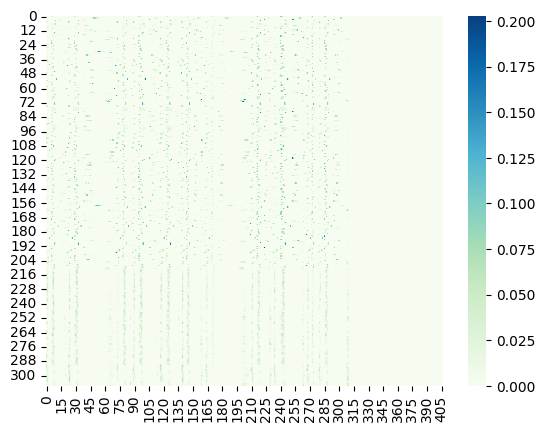

In [ ]:
e                   = 0
best_loss           = 20

checkpoint_root = os.path.join(os.getcwd(), "checkpoints-basic-transformer")
os.makedirs(checkpoint_root, exist_ok=True)
wandb.watch(model, log="all")

checkpoint_best_loss_model_filename     = 'checkpoint-best-loss-model.pth'
checkpoint_last_epoch_filename          = 'checkpoint-epoch-.pth'
best_loss_model_path                    = os.path.join(checkpoint_root, checkpoint_best_loss_model_filename)
epoch_model_path                        = os.path.join(checkpoint_root, checkpoint_last_epoch_filename)
if RESUME_LOGGING:
    # change if you want to load best test model accordingly
    # checkpoint = torch.load(wandb.restore(checkpoint_best_loss_model_filename, run_path=""+run_id).name)
    model, optimizer, scheduler, epoch, metric = load_model(epoch_model_path, model, metric= "train_loss", optimizer= optimizer, scheduler= scheduler)
    # model.load_state_dict(checkpoint['model_state_dict'])
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    e = epoch

    print("Resuming from epoch {}".format(epoch+1))
    print("Epochs left: ", config['epochs']-epoch)
    print("Optimizer: \n", optimizer)
    print("Scheduler: \n", scheduler.state_dict())
    print("metric: \n", metric)
    scheduler.T_max = 75
    print("Scheduler: \n", scheduler.state_dict())

torch.cuda.empty_cache()
gc.collect()

epochs = config["epochs"]
for epoch in range(e, epochs):

    print("\nEpoch {}/{}".format(epoch+1, config["epochs"]))

    curr_lr = float(optimizer.param_groups[0]["lr"])

    train_loss, train_perplexity, attention_weights = train_model(model, train_loader, optimizer)

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Train Perplexity {:.04f}\t Learning Rate {:.09f}".format(
        epoch + 1, config["epochs"], train_loss, train_perplexity, curr_lr))

    if (epoch % 2 == 0):    # validate every 2 epochs to speed up training
        levenshtein_distance = validate_fast(model, val_loader)
        print("Levenshtein Distance {:.04f}".format(levenshtein_distance))

        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr,
                "val_distance"      : levenshtein_distance})

    else:
        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr})

    # plotting the encoder-nearest and decoder-nearest attention weights
    attention_keys = list(attention_weights.keys())

    attention_weights_decoder_self       = attention_weights[attention_keys[0]][0].cpu().detach().numpy()
    attention_weights_decoder_cross      = attention_weights[attention_keys[-1]][0].cpu().detach().numpy()

    # saving the cross-attention weights
    save_attention_plot(attention_weights_decoder_cross, epoch+100)

    # plot_attention_weights((attention_weights[attention_keys[0]][0]).cpu().detach().numpy())
    # plot_attention_weights(attention_weights[attention_keys[-1]][0].cpu().detach().numpy())

    if config["scheduler"] == "ReduceLR":
        scheduler.step(levenshtein_distance)
    else:
        scheduler.step()

    ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best
    epoch_model_path = os.path.join(checkpoint_root, (checkpoint_last_epoch_filename + str(epoch) + '.pth'))
    save_model(model, optimizer, scheduler, ['train_loss', train_loss], epoch, epoch_model_path)
    ## wandb.save(epoch_model_path) ## Can't save on wandb for all epochs, may blow up storage

    print("Saved epoch model")

    if best_loss >= train_loss:
        best_loss = train_loss
        save_model(model, optimizer, scheduler, ['train_loss', train_loss], epoch, best_loss_model_path)
        # wandb.save(best_loss_model_path)
        print("Saved best training model")

### Finish your wandb run
# run.finish()

In [ ]:
valid_actual_distance = validate_full(model, val_loader)

## Testing

In [ ]:
model.eval()

# progress bar
batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc="Test", ncols=5)

all_predictions = []

for i, data in enumerate(test_loader):
    inputs, inputs_lengths = data
    inputs                 = inputs.to(device)

    with torch.inference_mode():
        greedy_predictions = model.recognize(inputs, inputs_lengths)

    greedy_predictions = greedy_predictions.detach().cpu().numpy()

    for batch_idx in range(greedy_predictions.shape[0]):
        pred_sliced = indices_to_chars(greedy_predictions[batch_idx], vocab= VOCAB)
        pred_string = ''.join(pred_sliced)
        all_predictions.append(pred_string)

    batch_bar.update()

Test: 100%|██████████| 41/41 [37:54<00:00, 66.53s/it]

In [ ]:
%cd /content/
df = pd.DataFrame({
    "index" : list(range(len(all_predictions))),
    "label" : all_predictions
})

df.to_csv("test.csv", index=False)

/content


In [ ]:
!kaggle competitions submit -c hw4p2-sp24 -f test.csv -m "HW4P2 Preliminary Submission"

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/kaggle/cli.py", line 67, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 561, in competition_submit_cli
    submit_result = self.competition_submit(file_name, message,
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 532, in competition_submit
    url_result['createUrl'], quiet)
KeyError: 'createUrl'


In [ ]:
# TODO Sumbit predictions to Kaggle

# PART #2 Full Transformer (Encoder-Decoder)

Using an LSTM encoder helps to capture some dependencies in the input sequence which helps the transformer decoder to decode. However, we can do more than that. The transformer encoder plays a crucial role by processing the input sequence into a high-dimensional space, capturing complex relationships between elements. It uses self-attention to understand the context around each feature, enabling the model to grasp subtle nuances and dependencies, crucial for our speech recognition task and improving performance.

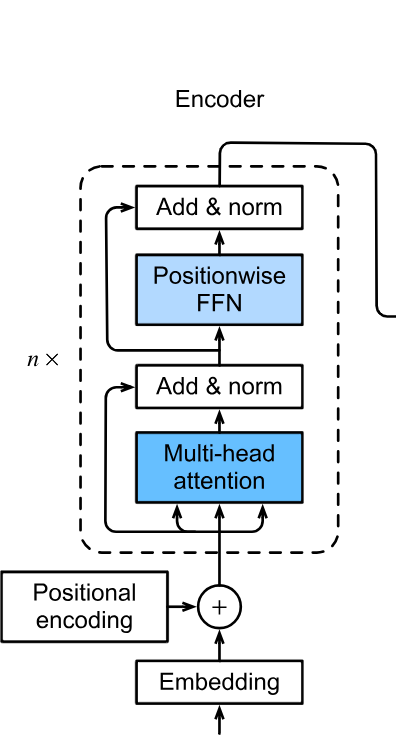

Tips in completing this section

* We will use the LSTM Encoder as input embedding.
* How many multi-head attention modules do we have.
* Can you seperate the encoder layer from the whole encoder architecture ?
* How do  we implement skip  connections
* How many layer norms do we have ?

## Transformer Encoder

In [31]:
class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        # @TODO: fill in the blanks appropriately (given the modules above)
        self.mha        = MultiHeadAttention(n_head=num_heads, d_model=d_model, dropout=dropout)
        self.ffn        = FeedForward(d_model, d_ff, dropout)

        self.layernorm1 = torch.nn.LayerNorm(d_model)
        self.layernorm2 = torch.nn.LayerNorm(d_model)
        self.dropout1   = torch.nn.Dropout(dropout)
        self.dropout2   = torch.nn.Dropout(dropout)

    def forward(self, inp):  # shape: (batch_size, time_length, d_model)

        # Multi-Head Attention
        #   (1) perform Multi-Head Attention on inp
        ''' TODO '''
        # print(f'The shape of inp is {inp.shape}')
        attn_output, _ = self.mha(q=inp, k=inp, v=inp)
        # Skip (Residual) Connection
        #   (1) perform dropout
        #   (2) add the input as a skip connection
        ''' TODO '''
        out1 = self.dropout1(attn_output) + inp
        # Layer Normalization
        #   (1) call layernorm on this resulting value
        ''' TODO '''
        layernorm_out1 = self.layernorm1(out1)
        # Feed Forward Network
        #   (1) apply feed forward layer
        ''' TODO '''
        ffn_out = self.ffn(layernorm_out1)
        # Skip (Residual) Connection
        #   (1) perform dropout
        #   (2) add the output of the first layernorm as a skip connection
        ''' TODO '''
        out2 = self.dropout2(ffn_out) + layernorm_out1
        # Layer Normalization
        #   (1) call layernorm on this resulting value
        ''' TODO '''
        layernorm_out2 = self.layernorm2(out2)  # shape: (batch_size, time_length, d_ff)
        return layernorm_out2

In [32]:
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, num_layers, d_model, num_heads, d_ff, mfcc_max_seq_length, dropout=0.1):
        super(Encoder, self).__init__()

        # @TODO: fill in the blanks appropriately (given the modules above and P1 setup)
        self.embedding      = CNN_LSTM_Encoder(input_size=input_dim, encoder_hidden_size=256, enc_dropout=dropout)
        self.projection     = torch.nn.Linear(1024, d_model)
        self.positional_encoding    = PositionalEncoding(d_model=d_model, max_len=mfcc_max_seq_length)

        # concatenating all num_layers EncoderLayer blocks
        self.enc_layers     = torch.nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.dropout        = torch.nn.Dropout(p=dropout)
        self.layernorm      = torch.nn.LayerNorm(d_model)

    def forward(self, x, input_lengths):

        # apply the CNN-LSTM Encoder (embedding)
        ''' TODO '''
        # print(f'The shape before embedding is {x.shape}')
        embedding_out, embedding_out_length = self.embedding(x, input_lengths)  # shape: (batch_size, time_length, features)
        # print(f'The shape of embedding_out is {embedding_out.shape}')
        # adding projection layer to change dimension of encoder_outputs to match d_model
        ''' TODO '''
        projection_out = self.projection(embedding_out)       # shape: (batch_size, time_length, d_model)
        # print(f'The shape of projection_out is {projection_out.shape}')
        # apply Positional Encoding on these extracted features
        ''' TODO '''
        position_out = self.positional_encoding(projection_out)   # shape: (batch_size, time_length, d_model)
        # print(f'The shape of position_out is {position_out.shape}')
        # apply dropout as regularization technique
        ''' TODO '''
        out = self.dropout(position_out) #   shape: (batch_size, time_length, d_model)
        # print(f'The shape of dropout is {out.shape}')
        # passing inputs through Transformer Encoder blocks
        ''' TODO '''
        for i, layer in enumerate(self.enc_layers):
            out = layer(out)     # shape: (batch_size, time_length, d_ff)
            # all_attention_weights[f'layer_{i+1}_weight1'] = attention_weights1   # I Think shape is (batch_size, target_time_length, target_time_length)
            # all_attention_weights[f'layer_{i+1}_weight2'] = attention_weights2   # I Think shape is (batch_size, target_time_length, input time length)
        return out, embedding_out_length

In [33]:
class FullTransformer(torch.nn.Module):
    def __init__(self, input_dim, enc_num_layers, dec_num_layers, enc_num_heads, dec_num_heads,
                 d_model, d_ff, target_vocab_size, eos_token, sos_token,
                 pad_token, dropout=0.1, trans_max_seq_length=550, mfcc_max_seq_length=3260):

        super(FullTransformer, self).__init__()

        self.encoder = Encoder(input_dim, enc_num_layers, d_model, enc_num_heads, d_ff,
                               mfcc_max_seq_length,  dropout)

        self.decoder = Decoder(dec_num_layers, d_model, dec_num_heads, d_ff,
                               dropout, target_vocab_size, trans_max_seq_length, eos_token, sos_token, pad_token)

    def forward(self, padded_input, input_lengths, padded_target, target_lengths):
        # passing through Encoder
        encoder_output, encoder_lens = self.encoder(padded_input, input_lengths)

        # passing Encoder output and Attention masks through Decoder
        output, attention_weights = self.decoder(padded_target, encoder_output, encoder_lens)

        return output, attention_weights

    def recognize(self, inp, inp_len):
        """ sequence-to-sequence greedy search -- decoding one utterance at a time """

        encoder_outputs, encoder_lens = self.encoder(inp, inp_len)
        out = self.decoder.recognize_greedy_search(encoder_outputs, encoder_lens)

        return out

## Full Model Setup

In [35]:
full_model = FullTransformer(
input_dim                   = 27,
enc_num_layers              = config['enc_num_layers'],
dec_num_layers              = config['dec_num_layers'],
enc_num_heads               = config['enc_num_heads'],
dec_num_heads               = config['dec_num_heads'],

d_model                     = config['d_model'],
d_ff                        = config['d_ff'],

target_vocab_size           = len(VOCAB),
eos_token                   = EOS_TOKEN,
sos_token                   = SOS_TOKEN,
pad_token                   = PAD_TOKEN,

dropout                     = config['enc_dropout'],

# decrease to a small number if you are just trying to implement the network
# we've computed the max length of the transcripts for you
trans_max_seq_length        = 550,
mfcc_max_seq_length         = dataset_max_len).to(device)



# para_full = num_parameters(full_model)
# print("#"*10)
# print(f"Model Parameters:\n {para_full}")
# print("#"*10)

print(full_model)

FullTransformer(
  (encoder): Encoder(
    (embedding): CNN_LSTM_Encoder(
      (embedding): Sequential(
        (0): Conv1d(27, 54, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): BatchNorm1d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv1d(54, 108, kernel_size=(5,), stride=(1,), padding=(2,))
        (4): BatchNorm1d(108, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
      (bilstm): LSTM(108, 256, batch_first=True, dropout=0.2, bidirectional=True)
      (pBLSTMs): Sequential(
        (0): pBLSTM(
          (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
        )
        (1): LockedDropout()
        (2): pBLSTM(
          (blstm): LSTM(1024, 512, batch_first=True, bidirectional=True)
        )
        (3): LockedDropout()
      )
      (permute): Permute()
    )
    (projection): Linear(in_features=1024, out_features=512, bias=True)

In [ ]:
### Load your best P1 model checkpoint
model.load_state_dict(torch.load('/content/checkpoints-basic-transformer/checkpoint-best-loss-model.pth')['model_state_dict'])

<All keys matched successfully>

Freezing model weights except for transformer encoder layers. This is like an initialization strategy so that the encoder learns the range of values required by the decoder. After about 3 epochs when this initialzation is done, unfreeze weights of the entire model and let it train.




In [ ]:
### Copy weights from P1 model to full model
### Freeze the weights of full transformer input embedding, linear projection, and decoder

full_model.encoder.embedding.load_state_dict(model.encoder.state_dict())
for param in full_model.encoder.embedding.parameters():
    param.requires_grad = False # TODO make it non-trainable

full_model.encoder.projection.load_state_dict(model.proj.state_dict())
for param in full_model.encoder.projection.parameters():
    param.requires_grad = False # TODO make it non-trainable

full_model.decoder.load_state_dict(model.decoder.state_dict())
for param in full_model.decoder.parameters():
    param.requires_grad = False # TODO make it non-trainable

## Loss, Optimizer, and Scheduler Definitions

In [38]:
loss_func   = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)
scaler      = torch.cuda.amp.GradScaler()

In [39]:
''' defining optimizer '''

if config["optimizer"] == "SGD":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.SGD(full_model.parameters(),
                              lr=config["learning_rate"],
                              momentum=config["momentum"],
                              weight_decay=1E-4,
                              nesterov=config["nesterov"])

elif config["optimizer"] == "Adam":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.Adam(full_model.parameters(),
                               lr=float(config["learning_rate"]),
                               weight_decay=1e-4)

elif config["optimizer"] == "AdamW":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.AdamW(full_model.parameters(), lr=float(config["learning_rate"]),
                                betas=(0.9, 0.999),
                                eps=1e-9,
                                weight_decay=0.01)

''' defining scheduler '''

if config["scheduler"] == "ReduceLR":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                factor=config["factor"], patience=config["patience"], min_lr=1E-8, verbose=True)

elif config["scheduler"] == "CosineAnnealing":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                T_max = config["epochs"], eta_min=1E-8)

## WandB

In [ ]:
# using WandB? resume training?

USE_WANDB = True
RESUME_LOGGING = False


# creating your WandB run
run_name = "{}_Transformer_ENC-{}/{}_DEC-{}/{}_{}_{}_{}_{}_Lr:{}".format(
    config["Name"],
    config["enc_num_layers"],       # only used in Part II with the Transformer Encoder
    config["enc_num_heads"],        # only used in Part II with the Transformer Encoder
    config["dec_num_layers"],
    config["dec_num_heads"],
    config["d_model"],
    config["d_ff"],
    config["optimizer"],
    config["scheduler"],
    config['learning_rate'])

if USE_WANDB:

    wandb.login(key="b9fec08c02d03c41bdf5fe1f5268589277270fbe", relogin=True) # TODO enter your key here

    if RESUME_LOGGING:
        run_id = "f0bqyz1j"
        run = wandb.init(
            id     = run_id,        ### Insert specific run id here if you want to resume a previous run
            resume = True,          ### You need this to resume previous runs, but comment out reinit=True when using this
            project = "HW4P2-S24",  ### Project should be created in your wandb account
        )

    else:
        run = wandb.init(
            name    = run_name,     ### Wandb creates random run names if you skip this field, we recommend you give useful names
            reinit  = True,         ### Allows reinitalizing runs when you re-run this cell
            project = "HW4P2-S24",  ### Project should be created in your wandb account
            config  = config        ### Wandb Config for your run
        )

        ### Save your model architecture as a string with str(model)
        model_arch  = str(full_model)

        ### Save it in a txt file
        arch_file   = open("model_arch.txt", "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()

        ### Log it in your wandb run with wandb.save()
        wandb.save("model_arch.txt")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


learning_rate,█▇▅▁
train_loss,█▅▃▁
train_perplexity,█▅▃▁
val_distance,█▁
learning_rate,0.0001
train_loss,0.66079
train_perplexity,1.93691
val_distance,33.725


## Experiments


Epoch 1/50



Epoch 1/50: 
Train Loss 0.6309	 Train Perplexity 1.8806	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [01:25<59:48, 85.44s/it, running_distance=37.6875]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRING THAT IN ABLE SOLUND IN A TRANCE TO HOW HIS BODY STIFF AND UNSUMPORTANTED EXCEPTED TO POINTS THE HEND AND HEALS


Val:   5%|▍         | 2/43 [01:40<30:15, 44.29s/it, running_distance=28.6172]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HAD GENTLY AND GRATITUDE WHERE TO YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:11<25:22, 38.06s/it, running_distance=29.8646]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CAREL EXPOSED HIM TO THE PENLED HIS OF THE JULY AND LAW BOTHS IN A FEW OBER MENTS AND A SIPPERSISIONS AGE HE WAS THE CURE OF AND EVEN OF PRACE


Val:   9%|▉         | 4/43 [02:42<22:51, 35.17s/it, running_distance=31.0938]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AND THE SCAPE MORE IT MORE FROM INTENCITY PORT SUNDERSTANDING


Val:  12%|█▏        | 5/43 [04:05<33:11, 52.40s/it, running_distance=34.5781]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  WITH THE EDDER INTO HIS DUPEN WITH SUFFICIENT WANTER TO COVERT LET ITS TWO GENTLY TO QUITE THEN WHEN TAKE IT OUT TO COAK


Levenshtein Distance 34.5781
Saved epoch model
Saved best training model

Epoch 2/50



Epoch 2/50: 
Train Loss 0.5918	 Train Perplexity 1.8077	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 3/50



Epoch 3/50: 
Train Loss 0.5572	 Train Perplexity 1.7463	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:25<17:30, 25.00s/it, running_distance=31.5469]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THAT IN ABLE SOLUND IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTANTED EXCEPTED TO POINTS THE HEND AND HEALS


Val:   5%|▍         | 2/43 [00:43<14:32, 21.28s/it, running_distance=24.4297]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY AND GRATITUDE WHERE TOO HAVE BE THEN AT ALL


Val:   7%|▋         | 3/43 [01:19<18:29, 27.74s/it, running_distance=25.3854]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CAREL EXPOSED HIM TO THE PENLED HIS OF THE JULY IN LAW BUT IN A FEEBLE GAVER MEN SAME A SIPPORSITIOUS AGE HE WAS THE KIROVER INCUNITY AND EVEN OF PRAYS


Val:   9%|▉         | 4/43 [02:41<32:04, 49.36s/it, running_distance=28.4219]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  FLEE RANGE WHITER LAST LONGER AT THE SCEEP MORE AT MORE FROM INTENSITY PORTS UNDERSTANDING


Val:  12%|█▏        | 5/43 [04:04<38:58, 61.54s/it, running_distance=29.9469]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  WITH THE UTTER INTO HIS DO PEN WITH SUFFICIENT WANDER TO COVERT LET IT STUDENLY TO QUITE THEN WHEN TAKE IT OUT TO COO


Levenshtein Distance 29.9469
Saved epoch model
Saved best training model

Epoch 4/50



Epoch 4/50: 
Train Loss 0.5276	 Train Perplexity 1.6953	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 5/50



Epoch 5/50: 
Train Loss 0.5013	 Train Perplexity 1.6513	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:29<20:49, 29.75s/it, running_distance=24.9844]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINK THAT IN ABLE SOLEND IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUMPORTANTED EXCIPTED TRUE POINTS THE HEND AND HAILS


Val:   5%|▍         | 2/43 [00:44<14:29, 21.20s/it, running_distance=20.1562]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY AND GRATITUDE WHERE TO YOU HAVE BEEN AT ALL


Val:   7%|▋         | 3/43 [01:18<17:54, 26.87s/it, running_distance=21.1510]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CAREL EXPOSED HIM TO THE PENDLED HIS OF THE JULIAN LAW BUT IN A FEEBLE GOVER MEN SAME A SUPPERSISTIOUS AGE HE WAS THE CURE OF AND KINNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:51<19:05, 29.36s/it, running_distance=23.0977]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  FOR WE RANGE WHITER BLAST LONGER AT THE SCAPE MORE AT MORE FROM INTENCITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [03:14<30:53, 48.78s/it, running_distance=24.1781]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  WITH THE UTTER INTO HIS DUPEN WITH SUFFICIENT WANDER TO COVERED LET ITS TOO GENTLY TO QUITE THEN WHEN TAKE IT OUT TO COOK


Levenshtein Distance 24.1781
Saved epoch model
Saved best training model

Epoch 6/50



Epoch 6/50: 
Train Loss 0.4783	 Train Perplexity 1.6137	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 7/50



Epoch 7/50: 
Train Loss 0.4574	 Train Perplexity 1.5802	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [01:25<59:38, 85.21s/it, running_distance=28.6094]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THAT IN ABLE SOLEN IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUMPORTED EXCIPTED TRUE POINTS THE HEND AND HEELS


Val:   5%|▍         | 2/43 [01:42<31:04, 45.48s/it, running_distance=21.4922]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY AND GRATITUDE WHERE TO YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:18<27:13, 40.83s/it, running_distance=21.6615]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CAREL EXPOSED HIM TO THE PENDLED HIS OF THE JULIAN LAW BUT IN A FEEBLE GOVER MENTS AND A SUPPERSICIOUS AGE HE WAS THE KIR OF INCUNITY AND EVEN OF PRAYS


Val:   9%|▉         | 4/43 [03:40<37:15, 57.32s/it, running_distance=24.1016]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  FLEE RANGE WHITER BLAST LONGER AND THE SCAPE MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [05:04<42:13, 66.66s/it, running_distance=24.7344]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  FOR THE UTTER INTO A STUPEN WITH SUFFICIENT WANDER TO COVER IT LET ITS TWO GENTLY TO QUITE DONE WHEN TAKE IT OUT TO COO


Levenshtein Distance 24.7344
Saved epoch model
Saved best training model

Epoch 8/50



Epoch 8/50: 
Train Loss 0.4404	 Train Perplexity 1.5537	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 9/50



Epoch 9/50: 
Train Loss 0.4231	 Train Perplexity 1.5270	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:26<18:51, 26.93s/it, running_distance=21.7031]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINK THAT IN ABLE SOLEN IN A TRANCE TOOKLED AS BODY STIFF AND UNSUMPORTED EXCIPTED TWO POINTS THE HEND AND HAILS


Val:   5%|▍         | 2/43 [00:45<14:52, 21.77s/it, running_distance=17.8672]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY AND GRATITUDE WHERE TO YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:20<18:34, 27.87s/it, running_distance=18.9479]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CARROL EXPOSED HIM TO THE PENDLED HIS OF THE JULIAN LAW BUT IN A FEVIL GOVER MENTS AND A SUPPERSISIS AGE HE WAS THE CURE OF AND KINNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:43<32:13, 49.57s/it, running_distance=21.4219]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AT THE SCAPE MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [04:06<39:04, 61.71s/it, running_distance=22.1313]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  WITH THE UTTER INTO A STUPEN WITH SUFFICIENT WANDER TO COVER IT LED ITS TO GENTLY TO QUITE DONE WHEN TAKE IT OUT TO COO


Levenshtein Distance 22.1313
Saved epoch model
Saved best training model

Epoch 10/50



Epoch 10/50: 
Train Loss 0.4075	 Train Perplexity 1.5033	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 11/50



Epoch 11/50: 
Train Loss 0.3957	 Train Perplexity 1.4857	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:25<18:05, 25.84s/it, running_distance=20.9219]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINK THAT IN ABLE SO LONG IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCIPTED TO POINTS THE HEAD AND HEALS


Val:   5%|▍         | 2/43 [00:43<14:30, 21.23s/it, running_distance=16.9922]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY AND GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:16<17:38, 26.45s/it, running_distance=17.4844]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CAROL EXPOSED HIM TO THE PENDLED HIS OF THE JULIAN LAW BUT IN A FEVIL GOVER MEN AND A SUPERSISTIOUS AGE HE WAS THE CURE OF AND KINNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:39<31:41, 48.74s/it, running_distance=20.6719]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AT THE SCAPE MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [04:02<38:36, 60.97s/it, running_distance=21.2375]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  FOR THE UTTER INTO A STUPEN WITH SUFFICIENT WANDER TO COVER IT LET ITS DUGENTLY TOOK QUITE DONE WHEN TAKE IT OUT TO COO


Levenshtein Distance 21.2375
Saved epoch model
Saved best training model

Epoch 12/50



Epoch 12/50: 
Train Loss 0.3818	 Train Perplexity 1.4651	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 13/50



Epoch 13/50: 
Train Loss 0.3695	 Train Perplexity 1.4473	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:33<23:45, 33.94s/it, running_distance=21.3125]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINK THAT THE NABLE SOLUNG IN A TRANSED TO HOLD HIS BODY STIFF AND UNSUMPORTED EXCEPTED TRUE POINTS THE HEND AND HEELS


Val:   5%|▍         | 2/43 [00:51<16:37, 24.33s/it, running_distance=17.3594]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRATITUDE WORD TO YOU HAVE BE THEN AT ALL


Val:   7%|▋         | 3/43 [01:22<18:06, 27.17s/it, running_distance=17.5156]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CAROL EXPOSED HIM TO THE PENDLED HIS OF THE JULIAN LAW BUT IN A FEVIL GOVER MENTS AND A SUPERSISHES AGE HE WAS THE CURE OF INCUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:44<31:48, 48.94s/it, running_distance=19.8320]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AT THE SCAPE MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [04:07<38:46, 61.23s/it, running_distance=20.4281]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE UTTER INTO A STUPEN WITH SUFFICIENT WANDER TO COVER IT LET ITS TWO GENTLY TOO QUITE DONE WHEN TAKE IT OUT TO COOR


Levenshtein Distance 20.4281
Saved epoch model
Saved best training model

Epoch 14/50



Epoch 14/50: 
Train Loss 0.3595	 Train Perplexity 1.4328	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 15/50



Epoch 15/50: 
Train Loss 0.3496	 Train Perplexity 1.4188	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:32<22:39, 32.37s/it, running_distance=20.7969]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINK THAT IN NABLE SO LONG IN A TRANST TOOPLE AS BODY STIFF AND UNSUMPORTED EXCEPTED TRUE POINTS THE HEND AND HEELS


Val:   5%|▍         | 2/43 [00:48<15:24, 22.55s/it, running_distance=16.6797]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:03<31:02, 46.56s/it, running_distance=17.5469]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CAROL EXPOSED HIM TO THE PENDLED HIS OF THE JULIAN LAW BUT IN A FEVIAL GOVER MENTS AND A SUPERSISHES AGE HE WAS THE CURE OF INCUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:36<26:56, 41.44s/it, running_distance=18.9922]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AT THE SKEEP MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [03:59<35:40, 56.33s/it, running_distance=19.1594]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE UTTER INTO A STUPEN WITH SUFFICIENT WANDER TO COVER IT LET ITS TOO GENTLY TOOK QUITE DONE WHEN TAKE IT OUT TO COO


Levenshtein Distance 19.1594
Saved epoch model
Saved best training model

Epoch 16/50



Epoch 16/50: 
Train Loss 0.3400	 Train Perplexity 1.4052	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 17/50



Epoch 17/50: 
Train Loss 0.3312	 Train Perplexity 1.3929	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:28<19:46, 28.26s/it, running_distance=19.4688]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THAT ENABLE SO LONG IN A TRANSE TO HOLD HIS BODY STIFF AND UNSUMPORTED EXCEPTED TRUE POINTS THE HEAD AND HEALS


Val:   5%|▍         | 2/43 [00:44<14:18, 20.95s/it, running_distance=16.0703]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:58<30:22, 45.57s/it, running_distance=17.0990]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENDLED HIS OF THE JULIAN LAW BUT IN A FEVIL GOVER MENT AND A SUPERSISHES AGE HE WAS THE CURE OF INCUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [03:21<39:11, 60.31s/it, running_distance=19.2539]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AT THE SCAPE MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [04:44<43:16, 68.34s/it, running_distance=19.2281]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  FOR THE UTTER INTO A STUPEN WITH SUFFICIENT WANDER TO COVER IT LED ITS TOO GENTLY TOOK QUITE DONE WHEN TAKE IT OUT TO COO


Levenshtein Distance 19.2281
Saved epoch model
Saved best training model

Epoch 18/50



Epoch 18/50: 
Train Loss 0.3232	 Train Perplexity 1.3817	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 19/50



Epoch 19/50: 
Train Loss 0.3154	 Train Perplexity 1.3711	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:34<23:49, 34.04s/it, running_distance=19.0156]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THAT ENABLE SO LONG IN A TRANSE TO HOLD HIS BODY STIFF AND UNSUMPORTED EXCEPTED TWO POINTS THE HEND AND HEELS


Val:   5%|▍         | 2/43 [00:51<16:45, 24.53s/it, running_distance=15.0469]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRATITUDE WORDS YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:28<19:55, 29.88s/it, running_distance=15.3750]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CAROL EXPOSED HIM TO THE PENDLED HIS OF THE JULIAN LAW BUT IN A FEEBLE GOVER MENT AND A SUPERSISHES AGE HE WAS THE CURE OF INCUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:50<32:59, 50.76s/it, running_distance=17.5352]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AT THE SCAPE MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [04:13<39:29, 62.36s/it, running_distance=18.6125]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE UTTER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVER IT LET ITS TOO GENTLY TOOK QUITE DONE WHEN TAKE IT OUT TO COO


Levenshtein Distance 18.6125
Saved epoch model
Saved best training model

Epoch 20/50



Epoch 20/50: 
Train Loss 0.3081	 Train Perplexity 1.3610	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 21/50



Epoch 21/50: 
Train Loss 0.3013	 Train Perplexity 1.3517	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:28<20:14, 28.92s/it, running_distance=18.5312]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THE NABLE SO LONG IN A TRANSE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPTED TWO POINTS THE HEND AND HILLS


Val:   5%|▍         | 2/43 [00:44<14:29, 21.21s/it, running_distance=14.9609]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:20<18:34, 27.86s/it, running_distance=14.9844]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CAROL EXPOSED HIM TO THE PENDLED HIS OF THE JULIAN LAW BUT IN A FEVIL GOVERNMENTS AND A SUPERSISHES AGE HE WAS THE CURE OF INCUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:43<32:09, 49.49s/it, running_distance=17.2539]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AT THE SCAPE MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [04:05<38:55, 61.47s/it, running_distance=17.8281]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE UTTER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVER IT LET ITS TOO GENTLY TOOK QUITE DONE WHEN TAKE IT OUT TO COO


Levenshtein Distance 17.8281
Saved epoch model
Saved best training model

Epoch 22/50



Epoch 22/50: 
Train Loss 0.2958	 Train Perplexity 1.3444	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 23/50



Epoch 23/50: 
Train Loss 0.2890	 Train Perplexity 1.3353	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:32<22:29, 32.13s/it, running_distance=18.2656]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH THAT ENABLE SO LONG IN A TRANSE TO HOLD HIS BODY STIFF AND UNSUMPORTED EXCIPTED TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:47<15:23, 22.54s/it, running_distance=14.8203]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY AND GRATITUDE WORDS YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:17<17:10, 25.76s/it, running_distance=14.5156]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CAROL EXPOSED HIM TO THE PENDLED HIS OF THE JULIAN LAW BUT IN A FEVIL GOVER MEN AND A SUPER SISHES AGE HE WAS THE CURE OF INCUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:40<31:18, 48.17s/it, running_distance=16.7656]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER BLAST LONGER AT ESCAPE MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [04:02<38:17, 60.46s/it, running_distance=17.5375]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE UTTER INTO A STEW PEN WITH SUFFICIENT WANDER TO COVER IT LET ITS TOO GENTLY TOOK QUITE DONE WHEN TAKE IT OUT TO COO


Levenshtein Distance 17.5375
Saved epoch model
Saved best training model

Epoch 24/50



Epoch 24/50: 
Train Loss 0.2846	 Train Perplexity 1.3294	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 25/50



Epoch 25/50: 
Train Loss 0.2787	 Train Perplexity 1.3215	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:30<21:09, 30.22s/it, running_distance=18.4844]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH THAT ENABLE SO LONG IN A TRANSE TO HOLD HIS BODY STIFF AND UNSUMPORTAGE EXCEPTED TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:47<15:32, 22.74s/it, running_distance=14.6172]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRATITUDE WORDS YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:22<18:52, 28.32s/it, running_distance=14.3750]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CAROL EXPOSED HIM TO THE PENDLED HIS OF THE JULIAN LAW THAT IN A FEEBLE GOVER MEN AND A SUPERSISHES AGE HE WAS THE CURE OF INCUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:45<32:22, 49.81s/it, running_distance=16.8711]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AT ESCAPE MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [04:08<39:05, 61.72s/it, running_distance=17.0688]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE UTTER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVER IT LET ITS TOO GENTLY TOOK QUITE DONE WHEN TAKE IT OUT TO COO


Levenshtein Distance 17.0688
Saved epoch model
Saved best training model

Epoch 26/50



Epoch 26/50: 
Train Loss 0.2740	 Train Perplexity 1.3153	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 27/50



Epoch 27/50: 
Train Loss 0.2697	 Train Perplexity 1.3097	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:30<21:01, 30.04s/it, running_distance=17.5000]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLE SO ONE IN A TRANS TO HOLD HIS BODY STIFF AND UNSUMPORTED EXCEPTED TWO POINTS THE HEAD AND HILLS


Val:   5%|▍         | 2/43 [00:48<15:44, 23.04s/it, running_distance=13.8125]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY AND GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:02<31:04, 46.61s/it, running_distance=14.6094]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CAROL EXPOSED HIM TO THE PENDLED HIS OF THE JULIAN LAW THAT IN A FEEBLE GOVER MENT AND A SUPPER SICIOUS AGE HE WAS THE CURE OF INCUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [03:25<39:36, 60.93s/it, running_distance=16.8125]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AT THE SKEEP MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [04:48<43:37, 68.87s/it, running_distance=16.9906]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE UTTER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVER IT LET ITS TOO GENTLY TOOK QUITE DONE WHEN TAKE IT OUT TO COO


Levenshtein Distance 16.9906
Saved epoch model
Saved best training model

Epoch 28/50



Epoch 28/50: 
Train Loss 0.2650	 Train Perplexity 1.3036	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 29/50



Epoch 29/50: 
Train Loss 0.2609	 Train Perplexity 1.2982	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:32<22:31, 32.18s/it, running_distance=17.2812]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THAT ENABLE SO LONG IN A TRANST TOOK OLD HIS BODY STIFF AND UNSUMPORTED EXCIPTED TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:47<15:16, 22.37s/it, running_distance=13.5625]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRATITUDE WORDS YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:19<17:40, 26.52s/it, running_distance=13.4323]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENDLED HIS OF THE JULIAN LAW THUS IN A FEEBLE GOVER MEN AND A SUPER SICH HIS AGE HE WAS THE CURE OF INCUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:42<31:42, 48.79s/it, running_distance=15.8516]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AT ESCAPE MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [04:05<38:43, 61.16s/it, running_distance=16.0219]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE UTTER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVER IT LET ITS TOO GENTLY TOOK QUITE DONE WHEN TAKE IT OUT TO COO


Levenshtein Distance 16.0219
Saved epoch model
Saved best training model

Epoch 30/50



Epoch 30/50: 
Train Loss 0.2573	 Train Perplexity 1.2936	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 31/50



Epoch 31/50: 
Train Loss 0.2540	 Train Perplexity 1.2893	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [01:24<59:29, 84.99s/it, running_distance=19.5938]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINK THAT ENABLE SO LONG IN A TRANSE TOOK HOLD HIS BODY STIFF AND UNSUMPORTED EXCIPITED TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [01:42<31:02, 45.42s/it, running_distance=14.7422]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:12<25:28, 38.22s/it, running_distance=14.0208]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSITE HIM TO THE PENDLED HE'S OF THE JULIAN LAW BUT IN A FEEBLE GOVER MEN TO A SUPERSISHES AGE HE WAS THE CURE OF INCUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [03:34<36:11, 55.67s/it, running_distance=16.1719]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AT ESCAPE MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [04:57<41:28, 65.48s/it, running_distance=16.3719]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE UTTER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERENT LET ITS DO GENTLY TOOK QUITE DONE WHEN TAKE IT OUT TO COO


Levenshtein Distance 16.3719
Saved epoch model
Saved best training model

Epoch 32/50



Epoch 32/50: 
Train Loss 0.2507	 Train Perplexity 1.2850	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 33/50



Epoch 33/50: 
Train Loss 0.2476	 Train Perplexity 1.2810	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:34<24:23, 34.85s/it, running_distance=16.8438]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLE SO LONG IN A TRANSE TO HOLD HIS BODY STIFF AND UNSUMPORTED EXCEPTED TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:52<17:05, 25.01s/it, running_distance=13.2188]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY AND GRATITUDE WORDS YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:25<18:48, 28.22s/it, running_distance=12.9740]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSITE HIM TO THE PENDLE HE'S OF THE JULIAN LAW THUS IN A FEEBLE GOVER MEN TO AND A SUPERSISHES AGE HE WAS THE CURE OF INCUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:51<17:58, 27.64s/it, running_distance=14.3789]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AT ESCAPE MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [03:14<30:04, 47.49s/it, running_distance=14.8000]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE UTTER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVER IT LET ITS TOO GENTLY TOOK QUITE DONE WHEN TAKE IT OUT TO COO


Levenshtein Distance 14.8000
Saved epoch model
Saved best training model

Epoch 34/50



Epoch 34/50: 
Train Loss 0.2453	 Train Perplexity 1.2782	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 35/50



Epoch 35/50: 
Train Loss 0.2423	 Train Perplexity 1.2743	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:52<36:54, 52.73s/it, running_distance=17.4062]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THAT ENABLE SO LONG IN A TRANSE TO HOLD HIS BODY STIFF AND UNSUMPORTED EXCEPTED TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [01:08<21:08, 30.93s/it, running_distance=13.7656]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRATITUDE WORDS YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:38<20:17, 30.44s/it, running_distance=13.1615]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CAROL EXPOSED HIM TO THE PENDLED HIS OF THE JULIAN LAW THAT IN A FEEBLE GOVER MEN TO AND A SUPERSISHES AGE HE WAS THE CURE OF INCUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [03:00<33:06, 50.93s/it, running_distance=15.5977]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AT ESCAPE MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [04:23<39:33, 62.47s/it, running_distance=15.7344]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE UTTER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVER IT LET ITS DO GENTLY TOOK QUITE DONE WHEN TAKE IT OUT TO COO


Levenshtein Distance 15.7344
Saved epoch model
Saved best training model

Epoch 36/50



Epoch 36/50: 
Train Loss 0.2401	 Train Perplexity 1.2715	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 37/50



Epoch 37/50: 
Train Loss 0.2374	 Train Perplexity 1.2681	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:26<18:46, 26.83s/it, running_distance=17.2188]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLE SO LONG IN A TRANSE TO HOLD HIS BODY STIFF AND UNSUMPORTAGE EXCEPTED TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:42<13:51, 20.27s/it, running_distance=13.5000]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRATITUDE WORDS YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:57<30:04, 45.12s/it, running_distance=14.2031]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CAROL EXPOSED HIM TO THE PENDLED HIS OF THE JULIAN LAW THAT IN A FEEBLE GOVER MENT AND A SUPER SICH HIS AGE HE WAS THE CURE OF INCUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [03:19<38:57, 59.94s/it, running_distance=16.1445]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AT ESCAPE MORE AT MORE AT MORE FROM INENENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [04:42<43:08, 68.11s/it, running_distance=16.0125]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE UTTER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVER IT LET ITS TOO GENTLY TOOK QUITE DONE WHEN TAKE IT OUT TO COO


Levenshtein Distance 16.0125
Saved epoch model
Saved best training model

Epoch 38/50



Epoch 38/50: 
Train Loss 0.2359	 Train Perplexity 1.2662	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 39/50



Epoch 39/50: 
Train Loss 0.2341	 Train Perplexity 1.2638	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:52<37:04, 52.96s/it, running_distance=17.5938]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THAT ENABLE SO LONG IN A TRANS TO HOLD HIS BODY STIFF AND UNSUMPORTAGE EXCEPTED TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [01:08<21:11, 31.02s/it, running_distance=13.5625]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:23<33:58, 50.95s/it, running_distance=14.4167]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSITE HIM TO THE PENDLED HE'S OF THE JULIAN LAW THAT IN A FEEBLE GOVER MENT AND A SUPERSISHES AGE HE WAS THE CURE OF INCUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [03:45<41:11, 63.37s/it, running_distance=16.3086]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AT ESCAPE MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [05:08<44:34, 70.39s/it, running_distance=16.2094]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE UTTER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVER IT LET ITS TOO GENTLY TOOK QUITE DONE WHEN TAKE IT OUT TO COO


Levenshtein Distance 16.2094
Saved epoch model
Saved best training model

Epoch 40/50



Epoch 40/50: 
Train Loss 0.2325	 Train Perplexity 1.2619	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 41/50



Epoch 41/50: 
Train Loss 0.2309	 Train Perplexity 1.2599	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:26<18:51, 26.95s/it, running_distance=16.3594]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THAT ENABLE SO ONE IN A TRANSE TO HOLD HIS BODY STIFF AND UNSUMPORTAGE EXCEPTED TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:44<14:45, 21.59s/it, running_distance=12.8281]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRATITUDE WORDS YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:20<18:44, 28.11s/it, running_distance=12.8854]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENDLED HIS OF THE JULIAN LAW THAT IN A FEEBLE GOVER MEN TO AND A SUPER SICIOUS AGE HE WAS THE CURE OF INCUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:43<32:13, 49.57s/it, running_distance=15.1641]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AT ESCAPE MORE AT MORE AT MORE FROM INENENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [04:05<38:57, 61.51s/it, running_distance=15.1750]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE UTTER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVER IT LET ITS TOO GENTLY TOOK QUITE DONE WHEN TAKE IT OUT TO COO


Levenshtein Distance 15.1750
Saved epoch model
Saved best training model

Epoch 42/50



Epoch 42/50: 
Train Loss 0.2300	 Train Perplexity 1.2587	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 43/50



Epoch 43/50: 
Train Loss 0.2292	 Train Perplexity 1.2577	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:33<23:44, 33.92s/it, running_distance=17.1250]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THAT ENABLE SO LONG IN A TRANSE TO HOLD HIS BODY STIFF AND UNSUMPORTAGE EXCEPTED TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:49<15:52, 23.23s/it, running_distance=13.4062]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRATITUDE WORDS YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:04<31:07, 46.69s/it, running_distance=14.2448]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENDLED HIS OF THE JULIAN LAW THAT IN A FEEBLE GOVER MEN TO AND A SUPER SICH HIS AGE HE WAS THE CURE OF INCUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [03:26<39:34, 60.88s/it, running_distance=16.1914]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AT ESCAPE MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [04:49<43:36, 68.84s/it, running_distance=15.8469]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE UTTER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVER IT LET ITS TOO GENTLY TOOK QUITE DONE WHEN TAKE IT OUT TO COO


Levenshtein Distance 15.8469
Saved epoch model
Saved best training model

Epoch 44/50



Epoch 44/50: 
Train Loss 0.2280	 Train Perplexity 1.2562	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 45/50



Epoch 45/50: 
Train Loss 0.2279	 Train Perplexity 1.2561	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:33<23:29, 33.56s/it, running_distance=16.7812]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THAT ENABLE SO LONG IN A TRANSE TO HOLD HIS BODY STIFF AND UNSUMPORTAGE EXCEPTED TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:49<15:45, 23.06s/it, running_distance=13.1797]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRATITUDE WORDS YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:04<31:11, 46.79s/it, running_distance=13.9531]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENDLED HIS OF THE JULIAN LAW THAT IN A FEEBLE GOVERNMENT AND A SUPER SICH HIS AGE HE WAS THE CURE OF INCUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [03:26<39:31, 60.82s/it, running_distance=16.1641]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AT ESCAPE MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [04:49<43:34, 68.80s/it, running_distance=15.8594]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE UTTER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVER IT LET ITS TOO GENTLY TOOK QUITE DONE WHEN TAKE IT OUT TO COO


Levenshtein Distance 15.8594
Saved epoch model
Saved best training model

Epoch 46/50



Epoch 46/50: 
Train Loss 0.2267	 Train Perplexity 1.2546	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 47/50



Epoch 47/50: 
Train Loss 0.2265	 Train Perplexity 1.2543	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:51<36:00, 51.45s/it, running_distance=17.1250]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THAT ENABLE SO LONG IN A TRANSE TO HOLD HIS BODY STIFF AND UNSUMPORTAGE EXCEPTED TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [01:07<20:45, 30.38s/it, running_distance=13.4219]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRATITUDE WORDS YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:21<33:44, 50.62s/it, running_distance=14.0781]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENDLED HIS OF THE JULIAN LAW THAT IN A FEEBLE GOVERNMENT AND A SUPER SICH HIS AGE HE WAS THE CURE OF INCUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [03:44<41:07, 63.27s/it, running_distance=16.1797]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AT ESCAPE MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [05:07<44:35, 70.42s/it, running_distance=15.8344]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE UTTER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVER IT LET ITS TOO GENTLY TOOK QUITE DONE WHEN TAKE IT OUT TO COO


Levenshtein Distance 15.8344
Saved epoch model
Saved best training model

Epoch 48/50



Epoch 48/50: 
Train Loss 0.2266	 Train Perplexity 1.2544	 Learning Rate 0.0000
Saved epoch model

Epoch 49/50



Epoch 49/50: 
Train Loss 0.2258	 Train Perplexity 1.2534	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [01:24<59:27, 84.95s/it, running_distance=19.1562]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THAT ENABLE SO LONG IN A TRANSE TO HOLD HIS BODY STIFF AND UNSUMPORTAGE EXCEPTED TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [01:40<30:11, 44.19s/it, running_distance=14.3672]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRATITUDE WORDS YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:55<38:46, 58.16s/it, running_distance=14.7448]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENDLED HIS OF THE JULIAN LAW THAT IN A FEEBLE GOVERNMENT AND A SUPER SICH HIS AGE HE WAS THE CURE OF INCUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [04:18<44:07, 67.90s/it, running_distance=16.5469]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AT ESCAPE MORE AT MORE AT MORE FROM INENENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [05:41<46:26, 73.34s/it, running_distance=16.2375]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE UTTER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVER IT LET ITS TOO GENTLY TOOK QUITE DONE WHEN TAKE IT OUT TO COO


Levenshtein Distance 16.2375
Saved epoch model
Saved best training model

Epoch 50/50



Epoch 50/50: 
Train Loss 0.2262	 Train Perplexity 1.2539	 Learning Rate 0.0000
Saved epoch model


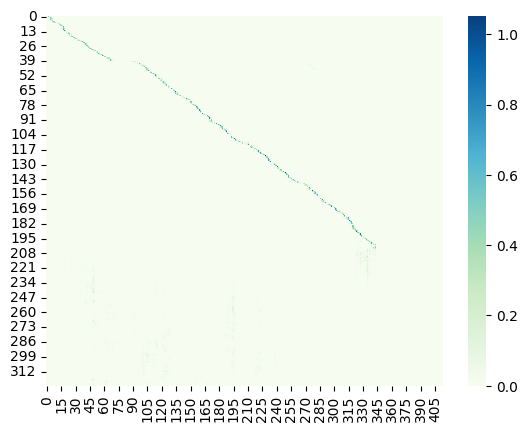

In [ ]:
###  Now let's train the encoder to master the encoder input ranges
e                   = 0
best_loss           = 10.0

checkpoint_root = os.path.join(os.getcwd(), 'checkpointsfull')
os.makedirs(checkpoint_root, exist_ok=True)
wandb.watch(full_model, log="all")

checkpoint_best_loss_model_filename     = 'checkpoint-best-loss-modelfull.pth'
checkpoint_last_epoch_filename          = 'checkpoint-epochfull-'
best_loss_model_path                    = os.path.join(checkpoint_root, checkpoint_best_loss_model_filename)

if RESUME_LOGGING:
    # change if you want to load best test model accordingly
    checkpoint = torch.load(wandb.restore(checkpoint_best_loss_model_filename, run_path=""+run_id).name)

    full_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    e = checkpoint['epoch']

    print("Resuming from epoch {}".format(e+1))
    print("Epochs left: ", config['epochs']-e)
    print("Optimizer: \n", optimizer)

torch.cuda.empty_cache()
gc.collect()

epochs = config["epochs"]
for epoch in range(e, epochs):

    print("\nEpoch {}/{}".format(epoch+1, config["epochs"]))

    curr_lr = float(optimizer.param_groups[0]["lr"])

    train_loss, train_perplexity, attention_weights = train_model(full_model, train_loader, optimizer)

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Train Perplexity {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config["epochs"], train_loss, train_perplexity, curr_lr))

    if (epoch % 2 == 0):    # validate every 2 epochs to speed up training
        levenshtein_distance = validate_fast(full_model, val_loader)
        print("Levenshtein Distance {:.04f}".format(levenshtein_distance))

        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr,
                "val_distance"      : levenshtein_distance})

    else:
        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr})

    # plotting the encoder-nearest and decoder-nearest attention weights
    attention_keys = list(attention_weights.keys())

    # plot_attention_weights((attention_weights[attention_keys[0]][0]).cpu().detach().numpy())
    # plot_attention_weights(attention_weights[attention_keys[-1]][0].cpu().detach().numpy())

    attention_weights_decoder_self       = attention_weights[attention_keys[0]][0].cpu().detach().numpy()
    attention_weights_decoder_cross      = attention_weights[attention_keys[-1]][0].cpu().detach().numpy()
    save_attention_plot(attention_weights_decoder_cross, epoch)

    if config["scheduler"] == "ReduceLR":
        scheduler.step(levenshtein_distance)
    else:
        scheduler.step()

    ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best
    epoch_model_path = os.path.join(checkpoint_root, (checkpoint_last_epoch_filename + str(epoch) + '.pth'))
    save_model(model, optimizer, scheduler, ['train_loss', train_loss], epoch, epoch_model_path)
    ## wandb.save(epoch_model_path) ## Can't save on wandb for all epochs, may blow up storage

    print("Saved epoch model")

    # the first time we add the transformer encoder block, we freeze all other weights
    #   except the transformer encoder weights and train this partially-frozen model
    #   for about 3 epochs to weight initialize the transformer encoder weights.
    #   This speeds up convergence of the entire network.
    # if epoch == 3:
    #     break

    if best_loss >= train_loss:
        best_loss = train_loss
        save_model(full_model, optimizer, scheduler, ['train_loss', train_loss], epoch, best_loss_model_path)
        # wandb.save(best_loss_model_path)
        print("Saved best training model")

### Finish your wandb run
# run.finish()

In [ ]:
validate_full(full_model, val_loader)

In [ ]:
### TODO Unfreeze the weights of full transformer input embedding and decoder
# @NOTE: after unfreezing, continue training the P2 model for more epochs to achieve best results!

for param in full_model.encoder.embedding.parameters():
    param.requires_grad = True # TODO make it trainable

for param in full_model.encoder.projection.parameters():
    param.requires_grad = True # TODO make it trainable

for param in full_model.decoder.parameters():
    param.requires_grad = True # TODO make it trainable

## Testing

In [ ]:
full_model.eval()

# progress bar
batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc="Test", ncols=5)

all_predictions = []

for i, data in enumerate(test_loader):
    inputs, inputs_lengths = data
    inputs                 = inputs.to(device)

    with torch.inference_mode():
        greedy_predictions = full_model.recognize(inputs, inputs_lengths)

    greedy_predictions = greedy_predictions.detach().cpu().numpy()

    for batch_idx in range(greedy_predictions.shape[0]):
        pred_sliced = indices_to_chars(greedy_predictions[batch_idx], vocab= VOCAB)
        pred_string = ''.join(pred_sliced)
        all_predictions.append(pred_string)

    batch_bar.update()

Test: 100%|██████████| 41/41 [37:12<00:00, 57.40s/it]

In [ ]:
%cd /content/
df = pd.DataFrame({
    "index" : list(range(len(all_predictions))),
    "label" : all_predictions
})

df.to_csv("improved.csv", index=False)

/content


In [ ]:
!kaggle competitions submit -c hw4p2-sp24 -f improved.csv -m "It's been a ride :)"

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/kaggle/cli.py", line 67, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 561, in competition_submit_cli
    submit_result = self.competition_submit(file_name, message,
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 532, in competition_submit
    url_result['createUrl'], quiet)
KeyError: 'createUrl'


# Part #3 (Improving your Model)
* Think of the input embedding, can you have something better than just an CNN-LSTM? Hint: HW3P2 might perform better.
* Think about the transformer encoder parameter, what about number of heads and number of layers, can this help?
* What about the decoder parameters what can  we improve there?
* We trained using an incremental training technique, can we use this technique to add more layers?

**Good Luck!!**

In [84]:
full_model = FullTransformer(
input_dim                   = 27,
enc_num_layers              = config['enc_num_layers'],
dec_num_layers              = config['dec_num_layers'],
enc_num_heads               = config['enc_num_heads'],
dec_num_heads               = config['dec_num_heads'],

d_model                     = config['d_model'],
d_ff                        = config['d_ff'],

target_vocab_size           = len(VOCAB),
eos_token                   = EOS_TOKEN,
sos_token                   = SOS_TOKEN,
pad_token                   = PAD_TOKEN,

dropout                     = config['enc_dropout'],

# decrease to a small number if you are just trying to implement the network
# we've computed the max length of the transcripts for you
trans_max_seq_length        = 550,
mfcc_max_seq_length         = dataset_max_len).to(device)

full_model.load_state_dict(torch.load('/content/checkpointsfull/checkpoint-best-loss-modelfull.pth')['model_state_dict'])

full_model_new = FullTransformer(
input_dim                   = 27,
enc_num_layers              = 3,
dec_num_layers              = config['dec_num_layers'],
enc_num_heads               = 2,
dec_num_heads               = config['dec_num_heads'],

d_model                     = config['d_model'],
d_ff                        = config['d_ff'],

target_vocab_size           = len(VOCAB),
eos_token                   = EOS_TOKEN,
sos_token                   = SOS_TOKEN,
pad_token                   = PAD_TOKEN,

dropout                     = config['enc_dropout'],

# decrease to a small number if you are just trying to implement the network
# we've computed the max length of the transcripts for you
trans_max_seq_length        = 550,
mfcc_max_seq_length         = dataset_max_len).to(device)

In [ ]:
def load_and_freeze_parameters(old_model, old_layers_number, new_model):
    #
    for old_layer, new_layer in zip(old_model.encoder.enc_layers, new_model.encoder.enc_layers):
        new_layer.load_state_dict(old_layer.state_dict())

    #
    for layer in new_model.encoder.enc_layers[0:old_layers_number]:
        for param in layer.parameters():
            param.requires_grad = False

    #
    for layer in new_model.encoder.enc_layers[old_layers_number:]:
        for param in layer.parameters():
            param.requires_grad = True



In [ ]:
load_and_freeze_parameters(full_model, 2, full_model_new)

In [94]:
# using WandB? resume training?

USE_WANDB = True
RESUME_LOGGING = True


# creating your WandB run
run_name = "{}_Transformer_ENC-{}/{}_DEC-{}/{}_{}_{}_{}_{}_Lr:{}".format(
    config["Name"],
    2,       # only used in Part II with the Transformer Encoder
    2,        # only used in Part II with the Transformer Encoder
    config["dec_num_layers"],
    config["dec_num_heads"],
    config["d_model"],
    config["d_ff"],
    config["optimizer"],
    config["scheduler"],
    config['learning_rate'])

if USE_WANDB:

    wandb.login(key="b9fec08c02d03c41bdf5fe1f5268589277270fbe", relogin=True) # TODO enter your key here

    if RESUME_LOGGING:
        run_id = "c4cdof4t"
        run = wandb.init(
            id     = run_id,        ### Insert specific run id here if you want to resume a previous run
            resume = True,          ### You need this to resume previous runs, but comment out reinit=True when using this
            project = "HW4P2-S24",  ### Project should be created in your wandb account
        )

    else:
        run = wandb.init(
            name    = run_name,     ### Wandb creates random run names if you skip this field, we recommend you give useful names
            reinit  = True,         ### Allows reinitalizing runs when you re-run this cell
            project = "HW4P2-S24",  ### Project should be created in your wandb account
            config  = config        ### Wandb Config for your run
        )

        ### Save your model architecture as a string with str(model)
        model_arch  = str(full_model_new)

        ### Save it in a txt file
        arch_file   = open("model_arch.txt", "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()

        ### Log it in your wandb run with wandb.save()
        wandb.save("model_arch.txt")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


learning_rate,████████████████▁▁▁▁▁▁
train_loss,▇██▇▇▇▆▇▆▆▅▄▄▄▄▄▃▃▁▁▁▁
train_perplexity,▇██▇▇▇▆▇▆▆▅▄▄▄▄▄▃▃▁▁▁▁
val_distance,▃▃▁▃▁█▄▃▃▄▄
learning_rate,9e-05
train_loss,0.07664
train_perplexity,1.07968
val_distance,14.725


## Loss, Optimizer, and Scheduler Definitions

In [95]:
loss_func   = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)
scaler      = torch.cuda.amp.GradScaler()

In [96]:
''' defining optimizer '''

if config["optimizer"] == "SGD":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.SGD(full_model.parameters(),
                              lr=config["learning_rate"],
                              momentum=config["momentum"],
                              weight_decay=1E-4,
                              nesterov=config["nesterov"])

elif config["optimizer"] == "Adam":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.Adam(full_model.parameters(),
                               lr=float(config["learning_rate"]),
                               weight_decay=1e-4)

elif config["optimizer"] == "AdamW":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.AdamW(full_model.parameters(),
                                lr=float(config["learning_rate"]),
                                weight_decay=0.01)

''' defining scheduler '''

if config["scheduler"] == "ReduceLR":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                factor=config["factor"], patience=config["patience"], min_lr=1E-8, verbose=True)

elif config["scheduler"] == "CosineAnnealing":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                T_max = config["epochs"], eta_min=1E-8)

Resuming from epoch 21
Epochs left:  80
Optimizer: 
 AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 9e-05
    maximize: False
    weight_decay: 0.01
)
Scheduler: 
 {'factor': 0.9, 'min_lrs': [1e-08], 'patience': 10, 'verbose': True, 'cooldown': 0, 'cooldown_counter': 0, 'mode': 'min', 'threshold': 0.0001, 'threshold_mode': 'rel', 'best': 11.825, 'num_bad_epochs': 5, 'mode_worse': inf, 'eps': 1e-08, 'last_epoch': 21, '_last_lr': [9e-05]}
metric: 
 0.07648311088471402
Scheduler: 
 {'factor': 0.9, 'min_lrs': [1e-08], 'patience': 6, 'verbose': True, 'cooldown': 0, 'cooldown_counter': 0, 'mode': 'min', 'threshold': 0.0001, 'threshold_mode': 'rel', 'best': inf, 'num_bad_epochs': 0, 'mode_worse': inf, 'eps': 1e-08, 'last_epoch': 0}

Epoch 21/100



Epoch 21/100: 
Train Loss 0.0761	 Train Perplexity 1.0791	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:42<29:40, 42.40s/it, running_distance=21.7812]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT A TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:59<18:38, 27.29s/it, running_distance=15.6328]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:25<17:57, 26.94s/it, running_distance=12.9271]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISTES AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:40<29:54, 46.03s/it, running_distance=15.7656]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET ITS DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 14.9594


Saved epoch model
Saved best training model

Epoch 22/100



Epoch 22/100: 
Train Loss 0.0758	 Train Perplexity 1.0788	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 23/100



Epoch 23/100: 
Train Loss 0.0758	 Train Perplexity 1.0788	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:42<29:50, 42.62s/it, running_distance=17.5000]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLDEST BODY STIFF AND UNSUPPORTED EXCEPTED TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:59<18:43, 27.41s/it, running_distance=12.0234]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:26<18:03, 27.09s/it, running_distance=10.2760]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JEWELLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISTES AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:41<30:05, 46.29s/it, running_distance=15.8867]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST BLONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET ITS DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 15.3562


Saved epoch model

Epoch 24/100



Epoch 24/100: 
Train Loss 0.0756	 Train Perplexity 1.0785	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 25/100



Epoch 25/100: 
Train Loss 0.0747	 Train Perplexity 1.0776	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:38<26:53, 38.41s/it, running_distance=16.0781]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLDEST BODY STIFF AND UNSUPPORTED EXCEPTED TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:54<17:28, 25.57s/it, running_distance=11.3516]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORNS YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:21<17:26, 26.17s/it, running_distance=9.7865]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISTES AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:36<29:34, 45.50s/it, running_distance=12.4570]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET ITS DUE GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 12.5094


Saved epoch model
Saved best training model

Epoch 26/100



Epoch 26/100: 
Train Loss 0.0751	 Train Perplexity 1.0780	 Learning Rate 0.0001
Saved epoch model

Epoch 27/100



Epoch 27/100: 
Train Loss 0.0747	 Train Perplexity 1.0776	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:38<27:14, 38.93s/it, running_distance=22.5312]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLDEST BODY STIFF AND UNSUPPORTED EXCEPTED TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:55<17:45, 25.98s/it, running_distance=14.6719]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:22<17:32, 26.31s/it, running_distance=12.1667]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISTES AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:21<25:34, 39.34s/it, running_distance=14.3594]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET ITS DUE GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 14.5781


Saved epoch model

Epoch 28/100



Epoch 28/100: 
Train Loss 0.0741	 Train Perplexity 1.0770	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 29/100



Epoch 29/100: 
Train Loss 0.0741	 Train Perplexity 1.0769	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:43<30:29, 43.56s/it, running_distance=15.2031]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANS TO HOLDEST BODY STIFF AND UNSUPPORTED EXCEPTED TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [01:00<18:55, 27.70s/it, running_distance=10.8516]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:27<18:13, 27.33s/it, running_distance=9.4115]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISTES AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:42<30:08, 46.37s/it, running_distance=11.6055]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET ITS DUE GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 11.6813


Saved epoch model
Saved best training model

Epoch 30/100



Epoch 30/100: 
Train Loss 0.0737	 Train Perplexity 1.0765	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 31/100



Epoch 31/100: 
Train Loss 0.0734	 Train Perplexity 1.0762	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:38<26:41, 38.13s/it, running_distance=19.9531]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT A TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:53<16:59, 24.87s/it, running_distance=13.4062]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:20<17:09, 25.75s/it, running_distance=11.2344]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISS'S AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:36<29:31, 45.42s/it, running_distance=15.0781]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST BLONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVER IT LET ITS DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 15.9656


Saved epoch model
Saved best training model

Epoch 32/100



Epoch 32/100: 
Train Loss 0.0733	 Train Perplexity 1.0761	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 33/100



Epoch 33/100: 
Train Loss 0.0728	 Train Perplexity 1.0756	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:45<31:48, 45.45s/it, running_distance=27.9688]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLDEST BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [01:02<19:35, 28.66s/it, running_distance=17.3281]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:29<18:30, 27.76s/it, running_distance=13.5365]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISSUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:44<30:18, 46.62s/it, running_distance=15.9492]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVER IT LET ITS DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 15.8031


Saved epoch model
Saved best training model

Epoch 34/100



Epoch 34/100: 
Train Loss 0.0726	 Train Perplexity 1.0754	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 35/100



Epoch 35/100: 
Train Loss 0.0718	 Train Perplexity 1.0745	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:41<28:54, 41.29s/it, running_distance=15.8594]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLDEST BODY STIFF AND UNSUPPORTED EXCEPT A TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:58<18:20, 26.85s/it, running_distance=11.1797]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:24<17:50, 26.76s/it, running_distance=9.7604]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW THUS IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:40<29:58, 46.10s/it, running_distance=13.5195]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WHITER LAST LONGER AND ESCAPED MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET IT'S DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 14.8688


Saved epoch model
Saved best training model

Epoch 36/100



Epoch 36/100: 
Train Loss 0.0723	 Train Perplexity 1.0750	 Learning Rate 0.0001
Epoch 00016: reducing learning rate of group 0 to 8.1000e-05.
Saved epoch model

Epoch 37/100



Epoch 37/100: 
Train Loss 0.0706	 Train Perplexity 1.0732	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:45<31:41, 45.27s/it, running_distance=15.4062]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT A TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [01:01<19:06, 27.96s/it, running_distance=11.1641]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORNDS YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:28<18:19, 27.48s/it, running_distance=9.6615]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:43<30:13, 46.50s/it, running_distance=13.3477]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPE MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET IT'S DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 13.0344


Saved epoch model
Saved best training model

Epoch 38/100



Epoch 38/100: 
Train Loss 0.0708	 Train Perplexity 1.0734	 Learning Rate 0.0001
Saved epoch model

Epoch 39/100



Epoch 39/100: 
Train Loss 0.0700	 Train Perplexity 1.0726	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:41<28:51, 41.24s/it, running_distance=17.5625]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT A TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:56<17:55, 26.23s/it, running_distance=12.3672]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORNS YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:23<17:39, 26.48s/it, running_distance=10.6406]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISTES AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:39<29:49, 45.88s/it, running_distance=14.1992]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET IT'S DUE GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 14.2000


Saved epoch model
Saved best training model

Epoch 40/100



Epoch 40/100: 
Train Loss 0.0703	 Train Perplexity 1.0729	 Learning Rate 0.0001
Saved epoch model

Epoch 41/100



Epoch 41/100: 
Train Loss 0.0694	 Train Perplexity 1.0719	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:34<24:19, 34.74s/it, running_distance=16.2344]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT A TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:50<16:02, 23.48s/it, running_distance=11.3594]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:16<16:36, 24.91s/it, running_distance=9.8125]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULIE IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISS'S AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:06<22:34, 34.74s/it, running_distance=11.9883]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET IT'S DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 11.7438


Saved epoch model
Saved best training model

Epoch 42/100



Epoch 42/100: 
Train Loss 0.0692	 Train Perplexity 1.0717	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 43/100



Epoch 43/100: 
Train Loss 0.0693	 Train Perplexity 1.0717	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:24<17:24, 24.87s/it, running_distance=13.1719]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLDEST BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:40<13:17, 19.45s/it, running_distance=10.0469]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORDS YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:07<15:10, 22.76s/it, running_distance=8.8906]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE DEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULIE IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:53<20:51, 32.10s/it, running_distance=11.2344]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET IT'S DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 11.2438


Saved epoch model

Epoch 44/100



Epoch 44/100: 
Train Loss 0.0697	 Train Perplexity 1.0723	 Learning Rate 0.0001
Saved epoch model

Epoch 45/100



Epoch 45/100: 
Train Loss 0.0682	 Train Perplexity 1.0707	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:38<27:08, 38.78s/it, running_distance=14.3594]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT A TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:55<17:36, 25.77s/it, running_distance=10.5781]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WERE NO YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:22<17:31, 26.28s/it, running_distance=9.2188]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULY IN LAW THAT'S IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:37<29:42, 45.70s/it, running_distance=11.9023]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET IT'S DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 11.9094


Saved epoch model
Saved best training model

Epoch 46/100



Epoch 46/100: 
Train Loss 0.0691	 Train Perplexity 1.0716	 Learning Rate 0.0001
Saved epoch model

Epoch 47/100



Epoch 47/100: 
Train Loss 0.0687	 Train Perplexity 1.0712	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:41<28:43, 41.05s/it, running_distance=18.8594]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT A TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:57<18:05, 26.47s/it, running_distance=12.8438]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:23<17:39, 26.48s/it, running_distance=10.9323]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISTES AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:39<29:48, 45.87s/it, running_distance=13.8203]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET IT'S DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 14.2781


Saved epoch model

Epoch 48/100



Epoch 48/100: 
Train Loss 0.0681	 Train Perplexity 1.0705	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 49/100



Epoch 49/100: 
Train Loss 0.0683	 Train Perplexity 1.0707	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:39<27:57, 39.93s/it, running_distance=17.6406]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLDEST BODY STIFF AND UNSUPPORTED EXCEPTED TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:56<17:53, 26.19s/it, running_distance=12.0625]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:23<17:36, 26.42s/it, running_distance=10.2448]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISTES AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:38<29:43, 45.73s/it, running_distance=12.8906]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET ITS DUE GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 13.2719


Saved epoch model

Epoch 50/100



Epoch 50/100: 
Train Loss 0.0677	 Train Perplexity 1.0701	 Learning Rate 0.0001
Epoch 00030: reducing learning rate of group 0 to 7.2900e-05.
Saved epoch model
Saved best training model

Epoch 51/100



Epoch 51/100: 
Train Loss 0.0675	 Train Perplexity 1.0698	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:43<30:24, 43.44s/it, running_distance=13.1094]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLDER'S BODY STIFF AND UNSUPPORTED EXCEPT A TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:59<18:50, 27.58s/it, running_distance=9.9062]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:26<18:04, 27.12s/it, running_distance=8.8125]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISTES AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:26<26:07, 40.20s/it, running_distance=12.1680]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET IT'S DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 12.2281


Saved epoch model
Saved best training model

Epoch 52/100



Epoch 52/100: 
Train Loss 0.0670	 Train Perplexity 1.0694	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 53/100



Epoch 53/100: 
Train Loss 0.0661	 Train Perplexity 1.0683	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:41<29:04, 41.52s/it, running_distance=20.7969]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPTED TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:58<18:24, 26.93s/it, running_distance=13.5859]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:24<17:53, 26.83s/it, running_distance=11.2604]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPORCED HIM TO THE PENALTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISTES AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:11<22:29, 34.61s/it, running_distance=14.1719]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVER IT LET IT'S DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 13.9469


Saved epoch model
Saved best training model

Epoch 54/100



Epoch 54/100: 
Train Loss 0.0665	 Train Perplexity 1.0688	 Learning Rate 0.0001
Saved epoch model

Epoch 55/100



Epoch 55/100: 
Train Loss 0.0660	 Train Perplexity 1.0683	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:44<30:53, 44.14s/it, running_distance=15.8438]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT A TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:59<18:38, 27.28s/it, running_distance=11.5703]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:26<17:56, 26.92s/it, running_distance=9.8958]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISTENCE AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:41<29:56, 46.07s/it, running_distance=13.3242]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET IT'S DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 14.5844


Saved epoch model
Saved best training model

Epoch 56/100



Epoch 56/100: 
Train Loss 0.0663	 Train Perplexity 1.0686	 Learning Rate 0.0001
Saved epoch model

Epoch 57/100



Epoch 57/100: 
Train Loss 0.0658	 Train Perplexity 1.0680	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:44<31:16, 44.67s/it, running_distance=17.7031]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT A TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [01:00<18:48, 27.53s/it, running_distance=12.1797]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:26<18:03, 27.09s/it, running_distance=10.1146]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISTES AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:13<22:41, 34.91s/it, running_distance=13.0391]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET IT'S DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 12.8469


Epoch 00037: reducing learning rate of group 0 to 6.5610e-05.
Saved epoch model
Saved best training model

Epoch 58/100



Epoch 58/100: 
Train Loss 0.0649	 Train Perplexity 1.0670	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 59/100



Epoch 59/100: 
Train Loss 0.0644	 Train Perplexity 1.0666	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:44<31:29, 44.98s/it, running_distance=16.4375]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLDEST BODY STIFF AND UNSUPPORTED EXCEPT A TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [01:01<19:17, 28.23s/it, running_distance=11.6562]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:28<18:23, 27.59s/it, running_distance=9.9062]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISTES AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:43<30:06, 46.33s/it, running_distance=12.6953]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET ITS DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 12.4062


Saved epoch model
Saved best training model

Epoch 60/100



Epoch 60/100: 
Train Loss 0.0645	 Train Perplexity 1.0666	 Learning Rate 0.0001
Saved epoch model

Epoch 61/100



Epoch 61/100: 
Train Loss 0.0640	 Train Perplexity 1.0662	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:21<14:49, 21.18s/it, running_distance=15.9844]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:37<12:31, 18.34s/it, running_distance=11.3281]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:04<14:44, 22.11s/it, running_distance=9.6302]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:50<20:40, 31.82s/it, running_distance=11.6562]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET ITS DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 11.4187


Saved epoch model
Saved best training model

Epoch 62/100



Epoch 62/100: 
Train Loss 0.0639	 Train Perplexity 1.0660	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 63/100



Epoch 63/100: 
Train Loss 0.0637	 Train Perplexity 1.0658	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:39<27:40, 39.54s/it, running_distance=16.0625]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT A TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:56<17:49, 26.07s/it, running_distance=11.2344]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:22<17:35, 26.38s/it, running_distance=9.5729]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISTES AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:38<29:45, 45.79s/it, running_distance=12.9453]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET IT'S DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 13.0781


Saved epoch model
Saved best training model

Epoch 64/100



Epoch 64/100: 
Train Loss 0.0636	 Train Perplexity 1.0656	 Learning Rate 0.0001
Epoch 00044: reducing learning rate of group 0 to 5.9049e-05.
Saved epoch model
Saved best training model

Epoch 65/100



Epoch 65/100: 
Train Loss 0.0630	 Train Perplexity 1.0650	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:36<25:31, 36.46s/it, running_distance=18.8906]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT A TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:51<16:27, 24.09s/it, running_distance=12.7031]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY AND GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:18<16:50, 25.25s/it, running_distance=10.5938]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULIE IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISTES AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:33<29:15, 45.03s/it, running_distance=13.7031]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVER IT LET IT'S DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 13.0844


Saved epoch model
Saved best training model

Epoch 66/100



Epoch 66/100: 
Train Loss 0.0624	 Train Perplexity 1.0644	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 67/100



Epoch 67/100: 
Train Loss 0.0624	 Train Perplexity 1.0644	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:38<26:50, 38.34s/it, running_distance=15.1562]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPTED TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:53<17:00, 24.90s/it, running_distance=10.9062]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:20<17:07, 25.70s/it, running_distance=9.5000]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISTES AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:36<29:29, 45.38s/it, running_distance=12.9102]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET IT'S DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 13.0563


Saved epoch model
Saved best training model

Epoch 68/100



Epoch 68/100: 
Train Loss 0.0620	 Train Perplexity 1.0640	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 69/100



Epoch 69/100: 
Train Loss 0.0623	 Train Perplexity 1.0643	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:21<14:45, 21.08s/it, running_distance=18.5625]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:37<12:35, 18.42s/it, running_distance=12.5469]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORDS YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:04<14:49, 22.23s/it, running_distance=10.7135]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISTES AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:20<28:09, 43.31s/it, running_distance=14.4570]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPE MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVER IT LET IT'S DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 14.5406


Saved epoch model

Epoch 70/100



Epoch 70/100: 
Train Loss 0.0622	 Train Perplexity 1.0641	 Learning Rate 0.0001
Saved epoch model

Epoch 71/100



Epoch 71/100: 
Train Loss 0.0626	 Train Perplexity 1.0646	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:38<27:04, 38.67s/it, running_distance=18.2500]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT A TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:53<17:01, 24.92s/it, running_distance=12.5156]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY AND GRATITUDE WORDS YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:20<17:06, 25.66s/it, running_distance=10.5469]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISTES AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:35<29:25, 45.27s/it, running_distance=13.3867]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET IT'S DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 14.0625


Epoch 00051: reducing learning rate of group 0 to 5.3144e-05.
Saved epoch model

Epoch 72/100



Epoch 72/100: 
Train Loss 0.0617	 Train Perplexity 1.0636	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 73/100



Epoch 73/100: 
Train Loss 0.0611	 Train Perplexity 1.0630	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:42<29:49, 42.61s/it, running_distance=12.4844]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT A TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:59<18:36, 27.22s/it, running_distance=9.6328]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:25<17:58, 26.96s/it, running_distance=8.5469]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULIE IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISTES AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:41<29:58, 46.13s/it, running_distance=12.4688]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET IT'S DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 13.2281


Saved epoch model
Saved best training model

Epoch 74/100



Epoch 74/100: 
Train Loss 0.0611	 Train Perplexity 1.0630	 Learning Rate 0.0001
Saved epoch model

Epoch 75/100



Epoch 75/100: 
Train Loss 0.0610	 Train Perplexity 1.0629	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:39<27:24, 39.17s/it, running_distance=23.5938]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT A TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:55<17:42, 25.90s/it, running_distance=14.8672]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:22<17:28, 26.22s/it, running_distance=12.0781]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISTES AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:13<23:30, 36.17s/it, running_distance=13.9062]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVER IT LET IT'S DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 14.2000


Saved epoch model
Saved best training model

Epoch 76/100



Epoch 76/100: 
Train Loss 0.0608	 Train Perplexity 1.0627	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 77/100



Epoch 77/100: 
Train Loss 0.0609	 Train Perplexity 1.0628	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:34<24:22, 34.82s/it, running_distance=20.1875]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPTED TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:51<16:29, 24.14s/it, running_distance=13.3281]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:18<16:53, 25.33s/it, running_distance=11.1510]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISTES AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:33<29:22, 45.19s/it, running_distance=15.3125]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPE MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVER IT LET IT'S DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 15.4406


Saved epoch model

Epoch 78/100



Epoch 78/100: 
Train Loss 0.0604	 Train Perplexity 1.0622	 Learning Rate 0.0001
Epoch 00058: reducing learning rate of group 0 to 4.7830e-05.
Saved epoch model
Saved best training model

Epoch 79/100



Epoch 79/100: 
Train Loss 0.0605	 Train Perplexity 1.0624	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:43<30:19, 43.31s/it, running_distance=15.5781]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT A TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [01:00<18:56, 27.73s/it, running_distance=11.0781]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:26<18:11, 27.30s/it, running_distance=9.5260]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISTES AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:42<30:09, 46.39s/it, running_distance=13.2148]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVER IT LET IT'S DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 13.8656


Saved epoch model

Epoch 80/100



Epoch 80/100: 
Train Loss 0.0596	 Train Perplexity 1.0615	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 81/100



Epoch 81/100: 
Train Loss 0.0594	 Train Perplexity 1.0612	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:43<30:13, 43.19s/it, running_distance=13.0938]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT A TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:58<18:25, 26.97s/it, running_distance=9.9297]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:25<17:53, 26.84s/it, running_distance=8.6354]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULY IN LAW THAT IN A FEEBLE GOVERNMENT AND A SUPERSISTES AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:40<29:53, 45.98s/it, running_distance=11.4961]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVER IT LET IT'S DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 12.0875


Saved epoch model
Saved best training model

Epoch 82/100



Epoch 82/100: 
Train Loss 0.0595	 Train Perplexity 1.0614	 Learning Rate 0.0000
Saved epoch model

Epoch 83/100



Epoch 83/100: 
Train Loss 0.0594	 Train Perplexity 1.0612	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:39<27:58, 39.97s/it, running_distance=21.6094]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT A TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:56<17:53, 26.19s/it, running_distance=14.1250]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:22<17:31, 26.29s/it, running_distance=11.4635]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISTES AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:38<29:42, 45.71s/it, running_distance=14.5117]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVER IT LET IT'S DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 14.0531


Saved epoch model

Epoch 84/100



Epoch 84/100: 
Train Loss 0.0593	 Train Perplexity 1.0612	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 85/100



Epoch 85/100: 
Train Loss 0.0586	 Train Perplexity 1.0604	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:38<26:59, 38.56s/it, running_distance=21.2656]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT A TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:55<17:36, 25.76s/it, running_distance=13.8203]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:21<17:25, 26.14s/it, running_distance=11.2396]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISTES AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:37<29:41, 45.67s/it, running_distance=14.5742]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGED WIDER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVER IT LET ITS DO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 15.2594


Epoch 00065: reducing learning rate of group 0 to 4.3047e-05.
Saved epoch model
Saved best training model

Epoch 86/100


Train:  88%|████████▊ | 392/446 [06:36<00:53,  1.01it/s, loss=0.0582, perplexity=1.0600]

KeyboardInterrupt: 

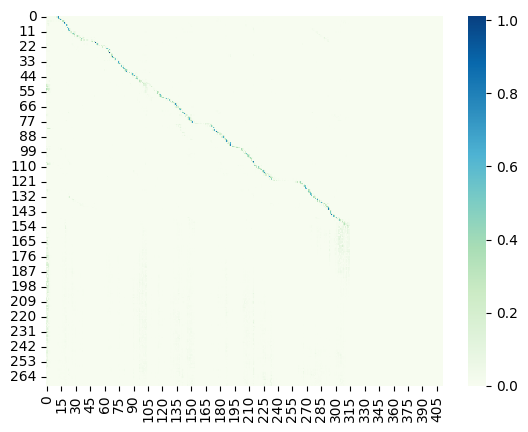

In [101]:
###  Now let's train the encoder to master the encoder input ranges
e                   = 0
best_loss           = 10.0

checkpoint_root = os.path.join(os.getcwd(), 'checkpointsfull')
os.makedirs(checkpoint_root, exist_ok=True)
wandb.watch(full_model, log="all")

checkpoint_best_loss_model_filename     = 'checkpoint-best-loss-modelfull.pth'
checkpoint_last_epoch_filename          = 'checkpoint-epochfull-'
best_loss_model_path                    = os.path.join(checkpoint_root, checkpoint_best_loss_model_filename)

if RESUME_LOGGING:
    # change if you want to load best test model accordingly
    # checkpoint = torch.load(wandb.restore(checkpoint_best_loss_model_filename, run_path=""+run_id).name)
    full_model, optimizer, scheduler, epoch, metric = load_model(best_loss_model_path, full_model, metric= "train_loss", optimizer= optimizer, scheduler= scheduler)
    # model.load_state_dict(checkpoint['model_state_dict'])
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    e = epoch

    print("Resuming from epoch {}".format(epoch+1))
    print("Epochs left: ", config['epochs']-epoch)
    print("Optimizer: \n", optimizer)
    print("Scheduler: \n", scheduler.state_dict())
    print("metric: \n", metric)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                factor=config["factor"], patience=config["patience"], min_lr=1E-8, verbose=True)
    print("Scheduler: \n", scheduler.state_dict())

torch.cuda.empty_cache()
gc.collect()

epochs = config["epochs"]
for epoch in range(e, epochs):

    print("\nEpoch {}/{}".format(epoch+1, config["epochs"]))

    curr_lr = float(optimizer.param_groups[0]["lr"])

    train_loss, train_perplexity, attention_weights = train_model(full_model, train_loader, optimizer)

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Train Perplexity {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config["epochs"], train_loss, train_perplexity, curr_lr))

    if (epoch % 2 == 0):    # validate every 2 epochs to speed up training
        levenshtein_distance = validate_fast(full_model, val_loader)
        print("Levenshtein Distance {:.04f}".format(levenshtein_distance))

        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr,
                "val_distance"      : levenshtein_distance})

    else:
        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr})

    # plotting the encoder-nearest and decoder-nearest attention weights
    attention_keys = list(attention_weights.keys())

    # plot_attention_weights((attention_weights[attention_keys[0]][0]).cpu().detach().numpy())
    # plot_attention_weights(attention_weights[attention_keys[-1]][0].cpu().detach().numpy())

    attention_weights_decoder_self       = attention_weights[attention_keys[0]][0].cpu().detach().numpy()
    attention_weights_decoder_cross      = attention_weights[attention_keys[-1]][0].cpu().detach().numpy()
    save_attention_plot(attention_weights_decoder_cross, epoch)

    if config["scheduler"] == "ReduceLR":
        scheduler.step(levenshtein_distance)
    else:
        scheduler.step()

    ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best
    epoch_model_path = os.path.join(checkpoint_root, (checkpoint_last_epoch_filename + str(epoch) + '.pth'))
    save_model(full_model, optimizer, scheduler, ['train_loss', train_loss], epoch, epoch_model_path)
    ## wandb.save(epoch_model_path) ## Can't save on wandb for all epochs, may blow up storage

    print("Saved epoch model")

    # the first time we add the transformer encoder block, we freeze all other weights
    #   except the transformer encoder weights and train this partially-frozen model
    #   for about 3 epochs to weight initialize the transformer encoder weights.
    #   This speeds up convergence of the entire network.
    # if epoch == 3:
    #     break

    if best_loss >= train_loss:
        best_loss = train_loss
        save_model(full_model, optimizer, scheduler, ['train_loss', train_loss], epoch, best_loss_model_path)
        # wandb.save(best_loss_model_path)
        print("Saved best training model")

### Finish your wandb run
# run.finish()

In [88]:
def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True



In [89]:
unfreeze_model(full_model)

In [102]:
full_model.load_state_dict(torch.load('/content/checkpointsfull/checkpoint-epochfull-4.pth')['model_state_dict'])


<All keys matched successfully>

## Testing

In [103]:
full_model.eval()

# progress bar
batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc="Test", ncols=5)

all_predictions = []

for i, data in enumerate(test_loader):
    inputs, inputs_lengths = data
    inputs                 = inputs.to(device)

    with torch.inference_mode():
        greedy_predictions = full_model.recognize(inputs, inputs_lengths)

    greedy_predictions = greedy_predictions.detach().cpu().numpy()

    for batch_idx in range(greedy_predictions.shape[0]):
        pred_sliced = indices_to_chars(greedy_predictions[batch_idx], vocab= VOCAB)
        pred_string = ''.join(pred_sliced)
        all_predictions.append(pred_string)

    batch_bar.update()

Test: 100%|██████████| 41/41 [32:09<00:00, 54.92s/it]

In [104]:
%cd /content/
df = pd.DataFrame({
    "index" : list(range(len(all_predictions))),
    "label" : all_predictions
})

df.to_csv("improved.csv", index=False)

/content


In [ ]:
!kaggle competitions submit -c hw4p2-sp24 -f improved.csv -m "It's been a ride :)"

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/kaggle/cli.py", line 67, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 561, in competition_submit_cli
    submit_result = self.competition_submit(file_name, message,
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 532, in competition_submit
    url_result['createUrl'], quiet)
KeyError: 'createUrl'


# HW3P2 model


### Pyramid Bi-LSTM (pBLSTM)

In [ ]:
# Utils for network
torch.cuda.empty_cache()
# from torch.autograd import Variable

class PermuteBlock(torch.nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

class LockedDropout(nn.Module):
    """ LockedDropout applies the same dropout mask to every time step.

    **Thank you** to Sales Force for their initial implementation of :class:`WeightDrop`. Here is
    their `License
    <https://github.com/salesforce/awd-lstm-lm/blob/master/LICENSE>`__.

    Args:
        p (float): Probability of an element in the dropout mask to be zeroed.
    """

    def __init__(self, p=0.25):
        self.p = p
        super().__init__()

    def forward(self, x):
        """
        Args:
            x (:class:`torch.FloatTensor` [sequence length, batch size, rnn hidden size]): Input to
                apply dropout too.
        """
        if not self.training or not self.p:
            return x
        x = x.clone()
        mask = x.new_empty(1, x.size(1), x.size(2), requires_grad=False).bernoulli_(1 - self.p)
        mask = mask.div_(1 - self.p)
        mask = mask.expand_as(x)
        return x * mask


    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'p=' + str(self.p) + ')'


In [ ]:
class pBLSTM(torch.nn.Module):

    '''
    Pyramidal BiLSTM
    Read the write up/paper and understand the concepts and then write your implementation here.

    At each step,
    1. Pad your input if it is packed (Unpack it)
    2. Reduce the input length dimension by concatenating feature dimension
        (Tip: Write down the shapes and understand)
        (i) How should  you deal with odd/even length input?
        (ii) How should you deal with input length array (x_lens) after truncating the input?
    3. Pack your input
    4. Pass it into LSTM layer

    To make our implementation modular, we pass 1 layer at a time.
    '''

    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()

        self.blstm = torch.nn.LSTM(input_size=2*input_size, hidden_size=hidden_size, num_layers=3, bidirectional=True, dropout = 0.3)  # TODO: Initialize a single layer bidirectional LSTM with the given input_size and hidden_size
        #could drop out
    def forward(self, x_packed): # x_packed is a PackedSequence

        # TODO: Pad Packed Sequence
        seq_unpacked, lens_unpacked = pad_packed_sequence(x_packed, batch_first=True)
        # print(f'in the plstm section after pad {seq_unpacked.shape},{lens_unpacked.shape}')
        # Call self.trunc_reshape() which downsamples the time steps of x and increases the feature dimensions as mentioned above
        x, x_lens = self.trunc_reshape(x=seq_unpacked, x_lens=lens_unpacked)
        # print(f'in the plstm section after truncate {x.shape},{x_lens.shape}')
        # self.trunc_reshape will return 2 outputs. What are they? Think about what quantites are changing.
        # TODO: Pack Padded Sequence. What output(s) would you get?
        PackedSequence = pack_padded_sequence(input=x,lengths=x_lens,batch_first=True,enforce_sorted=False)
        # TODO: Pass the sequence through bLSTM
        packed_output, (_, _) = self.blstm(PackedSequence)
        # What do you return?

        return packed_output

    def trunc_reshape(self, x, x_lens):
        # TODO: If you have odd number of timesteps, how can you handle it? (Hint: You can exclude them)
        # TODO: Reshape x. When reshaping x, you have to reduce number of timesteps by a downsampling factor while increasing number of features by the same factor
        # TODO: Reduce lengths by the same downsampling factor
        # The shape of x is [batch_size, frames, features]
        batch_size = x.shape[0]
        frames = x.shape[1]
        features = x.shape[2]
        if frames % 2 != 0:
            x = x[:, :-1, :]
        x = x.reshape((batch_size, x.shape[1]//2, features*2))
        x_lens = x_lens/2
        return x, x_lens

### Encoder

In [ ]:
class Encoder(torch.nn.Module):
    '''
    The Encoder takes utterances as inputs and returns latent feature representations
    '''
    def __init__(self, input_size, encoder_hidden_size):
        super(Encoder, self).__init__()

        self.PermuteBlock = PermuteBlock()
        self.embedding = torch.nn.Sequential(torch.nn.Conv1d(in_channels=input_size,out_channels=64,kernel_size=3,padding=1,stride=1),
                                             torch.nn.BatchNorm1d(64),
                                             torch.nn.GELU(),
                                             torch.nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
                                             torch.nn.BatchNorm1d(128),
                                             torch.nn.GELU(),
                                             torch.nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
                                             torch.nn.BatchNorm1d(256),
                                             torch.nn.GELU()
                                             )
        self.lstm_layers = torch.nn.ModuleList()
        for i in range(2):
            input_size_pblstm = 256 if i == 0 else encoder_hidden_size * 2
            self.lstm_layers.append(pBLSTM(input_size=input_size_pblstm, hidden_size=encoder_hidden_size))
            self.lstm_layers.append(LockedDropout())

    def forward(self, x, x_lens):
        # Where are x and x_lens coming from? The dataloader
        #TODO: Call the permute layer and embedding layer
        x = self.PermuteBlock(x)
        x = self.embedding(x)
        x = self.PermuteBlock(x)
        # # TODO: Pack Padded Sequence
        # packed = pack_padded_sequence(input=x,lengths=x_lens,batch_first=True,enforce_sorted=False)
        # # TODO: Pass Sequence through the pyramidal Bi-LSTM layer
        # x = self.pBLSTM1(packed)
        # # TODO: Pad Packed Sequence
        # encoder_outputs, encoder_lens= pad_packed_sequence(sequence=x,batch_first=True)
        # print(f'The output from plstm, {encoder_outputs.shape},{encoder_lens.shape}')
        for layer in self.lstm_layers:
            if isinstance(layer, pBLSTM):
                x_packed = pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)
                x_packed = layer(x_packed)
                x, x_lens = pad_packed_sequence(x_packed, batch_first=True)
            else:
                x = torch.permute(x, (1, 0, 2))
                x = layer(x)
                x = torch.permute(x,(1,0,2))
        # Remember the number of output(s) each function returns

        return x, x_lens


### Decoder

In [ ]:
class HW3P2_encoder(torch.nn.Module):

    def __init__(self, input_size, embed_size= 192):
        super().__init__()

        self.encoder        = Encoder(input_size=input_size, encoder_hidden_size=embed_size*2)

    def forward(self, x, lengths_x):

        encoder_out, encoder_lens   = self.encoder(x, lengths_x)
        return encoder_out, encoder_lens

## Initialize ASR Network

In [ ]:
HW3P2_encoder = HW3P2_encoder(
    input_size  = 27,
    embed_size  = 192,
).to(device)
print(HW3P2_encoder)

ASRModel(
  (augmentations): Sequential()
  (encoder): Encoder(
    (PermuteBlock): PermuteBlock()
    (embedding): Sequential(
      (0): Conv1d(27, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): GELU(approximate='none')
      (6): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): GELU(approximate='none')
    )
    (lstm_layers): ModuleList(
      (0): pBLSTM(
        (blstm): LSTM(512, 384, num_layers=3, dropout=0.3, bidirectional=True)
      )
      (1): LockedDropout(p=0.25)
      (2): pBLSTM(
        (blstm): LSTM(1536, 384, num_layers=3, dropout=0.3, bidirectional=True

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_augmentations,-,"[64, 2936, 27]",NaN,NaN
1_encoder.PermuteBlock_PermuteBlock,-,"[64, 27, 2936]",NaN,NaN
2_encoder.embedding.Conv1d_0,"[27, 64, 3]","[64, 64, 2936]",5248.0,15220224.0
3_encoder.embedding.BatchNorm1d_1,[64],"[64, 64, 2936]",128.0,64.0
4_encoder.embedding.GELU_2,-,"[64, 64, 2936]",NaN,NaN
5_encoder.embedding.Conv1d_3,"[64, 128, 3]","[64, 128, 2936]",24704.0,72155136.0
6_encoder.embedding.BatchNorm1d_4,[128],"[64, 128, 2936]",256.0,128.0
7_encoder.embedding.GELU_5,-,"[64, 128, 2936]",NaN,NaN
8_encoder.embedding.Conv1d_6,"[128, 256, 3]","[64, 256, 2936]",98560.0,288620544.0
